In [1]:
library(tidyverse)
library(vegan)
library(broom)
library(patchwork)

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   1.0.0 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: permute

Loading required package: lattice

This is vegan 2.6-4



# Beta diversity analysis of nasal 16S data

##### Michael Shaffer
##### 7/20/22
##### Merck ESC, Sys bio group

This notebook generates NMDS plots for looking at grouping of samples based on Nasal 16S microbiome abundances.

## Bring in the data

In [2]:
meta = read_csv('../../data/metadata/nasal/nasal_metadata.csv')
abx = read_csv('../../data/metadata/nasal/nasal_abx_usage.csv')
titers = read_csv('../../data/metadata/nasal/nasal_titers_yr1.csv')
meta = meta %>% add_column('age_at_collection' = as.double(difftime(meta$CollectionDate, meta$DOB, units='days'))) %>% mutate(Plate = as.factor(Plate))
meta = meta %>% left_join(abx, by='SampleID') %>% left_join(titers, by='SampleID')
head(meta)

Rows: 1008 Columns: 23
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (10): SubmissionType, SampleID, DiversigenCheckInSampleName, ReplacesLo...
dbl   (6): SampleNumber, SequencingType, BabyN, Plate, Row, Column
lgl   (5): SampleIDValidation, BabyN_checked, DOB_checked, CollectionDate_ch...
date  (2): DOB, CollectionDate

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1008 Columns: 6
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (1

SubmissionType  SampleNumber SampleID     SampleIDValidation
1 Primary in Tube 1            103_V5_NS_A1 NA                
2 Primary in Tube 2            106_V5_NS_A1 NA                
3 Primary in Tube 3            107_V2_NS_A1 NA                
4 Primary in Tube 4            107_V3_NS_A1 NA                
5 Primary in Tube 5            107_V5_NS_A1 NA                
6 Primary in Tube 6            108_V4_NS_A1 NA                
  DiversigenCheckInSampleName ReplacesLowVolumeSampleID BoxLocation SampleType
1 NA                          NA                        Box 1, A1   Nasal Swab
2 NA                          NA                        Box 1, A3   Nasal Swab
3 NA                          NA                        Box 1, A4   Nasal Swab
4 107_V8_NS_A1                NA                        Box 1, A5   Nasal Swab
5 NA                          NA                        Box 1, A8   Nasal Swab
6 NA                          NA                        Box 1, A9   Nasal Swab
  SampleSource SequencingType ⋯ median_mmNorm median_mmNorm_DTAPHib
1 Human Infant 16             ⋯         NA            NA           
2 Human Infant 16             ⋯ 0.06195543    0.05287358           
3 Human Infant 16             ⋯ 0.44948288    0.11401837           
4 Human Infant 16             ⋯ 0.44948288    0.11401837           
5 Human Infant 16             ⋯ 0.44948288    0.11401837           
6 Human Infant 16             ⋯ 0.00000000    0.00000000           
  median_mmNorm_PCV PT_protected Dip_protected FHA_protected PRN_protected
1          NA          NA           NA            NA            NA        
2 0.061955427       FALSE         TRUE          TRUE         FALSE        
3 0.958142022       FALSE         TRUE         FALSE          TRUE        
4 0.958142022       FALSE         TRUE         FALSE          TRUE        
5 0.958142022       FALSE         TRUE         FALSE          TRUE        
6 0.003102229       FALSE        FALSE         FALSE         FALSE        
  TET_protected PRP (Hib)_protected VR_group
1    NA           NA                NA      
2  TRUE         TRUE                NVR     
3  TRUE         TRUE                NVR     
4  TRUE         TRUE                NVR     
5  TRUE         TRUE                NVR     
6 FALSE         TRUE                LVR

In [3]:
abunds_gt10_rar10K = read.table('../../data/nasal/otu_table.gt10_rar10K.tsv', sep='\t')
head(abunds_gt10_rar10K)

Otu0001 Otu0002 Otu0003 Otu0004 Otu0005 Otu0006 Otu0007 Otu0008
101_S1_NS_A1 1       5845     117       9    0       2479    0       1329   
101_V3_NS_A1 0       9876       0       1    0          0    1         48   
101_V5_NS_A1 0        692     879    1104    0       3963    0       2003   
102_V1_NS_A1 1        557    4392       1    0          0    0         29   
102_V3_NS_A1 2        783    1428    6133    0          0    0          5   
102_V5_NS_A1 0        509     528     475    1          0    0          2   
             Otu0009 Otu0010 ⋯ Otu2849 Otu2850 Otu2851 Otu2853 Otu2854 Otu2855
101_S1_NS_A1   0     0       ⋯ 0       0       0       0       0       0      
101_V3_NS_A1   0     0       ⋯ 0       0       0       0       0       0      
101_V5_NS_A1 250     0       ⋯ 0       0       0       0       0       0      
102_V1_NS_A1 975     0       ⋯ 0       0       0       0       0       0      
102_V3_NS_A1 159     0       ⋯ 0       0       0       0       0       0      
102_V5_NS_A1 184     0       ⋯ 0       0       0       0       0       0      
             Otu2856 Otu2857 Otu2858 Otu2859
101_S1_NS_A1 0       0       0       0      
101_V3_NS_A1 0       0       0       0      
101_V5_NS_A1 0       0       0       0      
102_V1_NS_A1 0       0       0       0      
102_V3_NS_A1 0       0       0       0      
102_V5_NS_A1 0       0       0       0

## NMDS of all the data

First we will look at all the data at once. That way we can check the clustering of the controls relative to the test samples.

In [4]:
nmds = metaMDS(abunds_gt10_rar10K, k=3)

Square root transformation
Wisconsin double standardization
Run 0 stress 0.1748685 
Run 1 stress 0.1747963 
... New best solution
... Procrustes: rmse 0.02035419  max resid 0.1063759 
Run 2 stress 0.1803113 
Run 3 stress 0.1744728 
... New best solution
... Procrustes: rmse 0.003991801  max resid 0.05972145 
Run 4 stress 0.1746149 
... Procrustes: rmse 0.002622116  max resid 0.04515869 
Run 5 stress 0.1748496 
... Procrustes: rmse 0.01880304  max resid 0.1020446 
Run 6 stress 0.175889 
Run 7 stress 0.1750494 
Run 8 stress 0.1751113 
Run 9 stress 0.1742809 
... New best solution
... Procrustes: rmse 0.004803791  max resid 0.05794297 
Run 10 stress 0.1751145 
Run 11 stress 0.1745409 
... Procrustes: rmse 0.002965242  max resid 0.05044033 
Run 12 stress 0.1750825 
Run 13 stress 0.1752583 
Run 14 stress 0.1749676 
Run 15 stress 0.1840483 
Run 16 stress 0.1743608 
... Procrustes: rmse 0.002517426  max resid 0.04580427 
Run 17 stress 0.1755707 
Run 18 stress 0.1752315 
Run 19 stress 0.175369

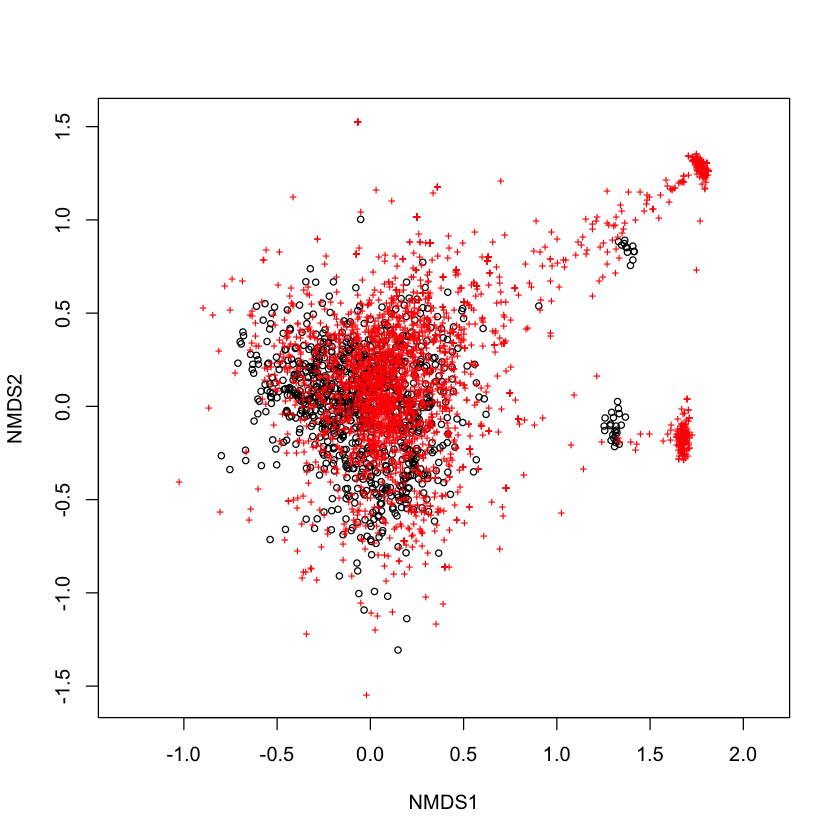

In [5]:
plot(nmds)

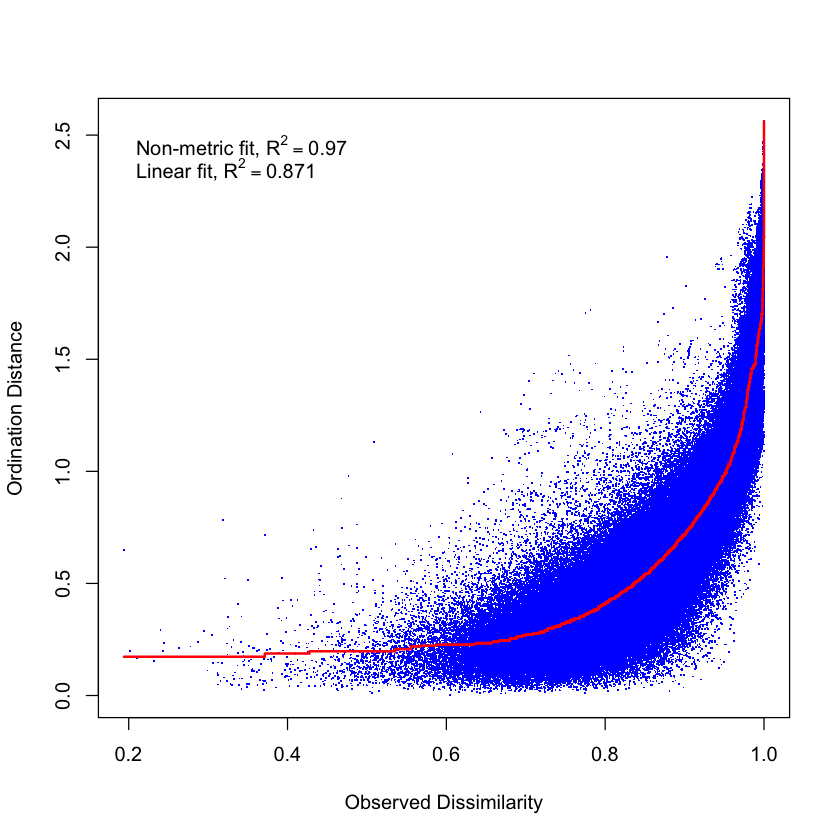

In [6]:
stressplot(nmds)

In [7]:
nmds$stress

[1] 0.1742809

SampleID     MDS1        MDS2        MDS3      
1 101_S1_NS_A1 -0.11346011 -0.48330319 -0.6579817
2 101_V3_NS_A1  0.19544101 -1.13833131 -0.3608307
3 101_V5_NS_A1 -0.13411408 -0.29187392 -0.1702466
4 102_V1_NS_A1  0.23634398 -0.29469238  0.1331089
5 102_V3_NS_A1  0.01540887 -0.25599641 -0.1526312
6 102_V5_NS_A1  0.23052528 -0.06668464 -0.3114392

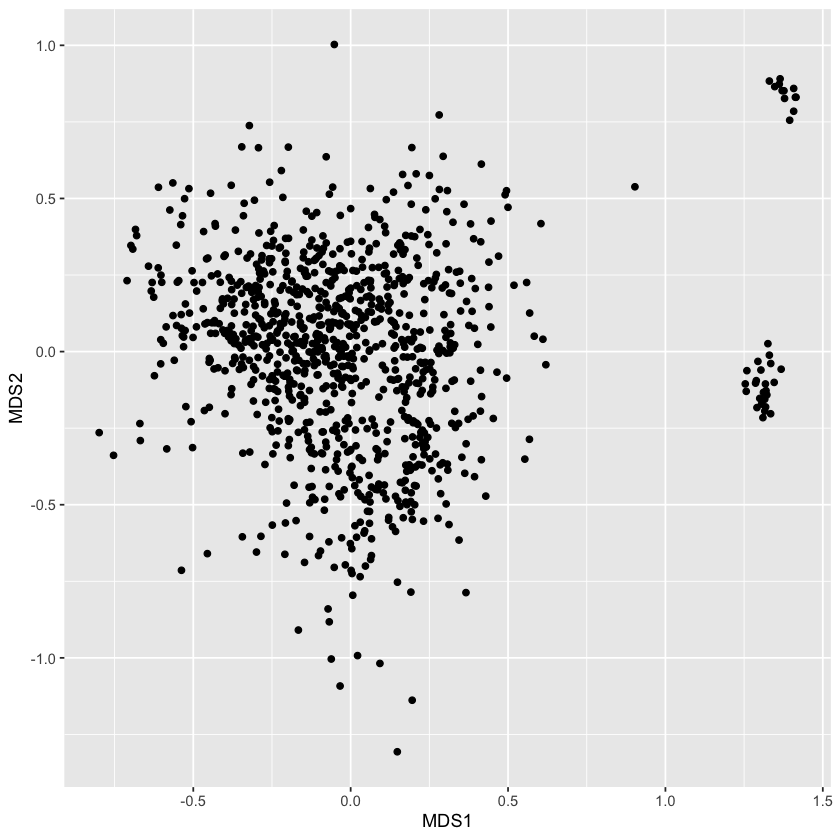

In [8]:
nmds_points = as_tibble(nmds$points, rownames='SampleID')
write_csv(nmds_points, '../../data/nasal/otu_nmds_all.csv')
head(nmds_points)
ggplot(nmds_points, aes(x=MDS1, y=MDS2)) + geom_point()

In [9]:
baby_samples = left_join(meta, nmds_points, by='SampleID')
controls = nmds_points %>% 
              filter(!SampleID %in% baby_samples$SampleID) %>%
              separate(SampleID, 'SampleType', remove=F, extra='drop')
nmds_w_meta = bind_rows(baby_samples, controls)
tail(nmds_w_meta)

SubmissionType SampleNumber SampleID   SampleIDValidation
1 NA             NA           MSA2002_7A NA                
2 NA             NA           MSA2002_7B NA                
3 NA             NA           MSA2002_8A NA                
4 NA             NA           MSA2002_8B NA                
5 NA             NA           MSA2002_9A NA                
6 NA             NA           MSA2002_9B NA                
  DiversigenCheckInSampleName ReplacesLowVolumeSampleID BoxLocation SampleType
1 NA                          NA                        NA          MSA2002   
2 NA                          NA                        NA          MSA2002   
3 NA                          NA                        NA          MSA2002   
4 NA                          NA                        NA          MSA2002   
5 NA                          NA                        NA          MSA2002   
6 NA                          NA                        NA          MSA2002   
  SampleSource SequencingType ⋯ PT_protected Dip_protected FHA_protected
1 NA           NA             ⋯ NA           NA            NA           
2 NA           NA             ⋯ NA           NA            NA           
3 NA           NA             ⋯ NA           NA            NA           
4 NA           NA             ⋯ NA           NA            NA           
5 NA           NA             ⋯ NA           NA            NA           
6 NA           NA             ⋯ NA           NA            NA           
  PRN_protected TET_protected PRP (Hib)_protected VR_group MDS1     MDS2       
1 NA            NA            NA                  NA       1.367689 -0.05749635
2 NA            NA            NA                  NA       1.299689 -0.15281813
3 NA            NA            NA                  NA       1.309740 -0.21573308
4 NA            NA            NA                  NA       1.318300 -0.18070079
5 NA            NA            NA                  NA       1.315585 -0.15548721
6 NA            NA            NA                  NA       1.330207 -0.01164225
  MDS3     
1 0.5838868
2 0.7072724
3 0.6097800
4 0.5689781
5 0.7471680
6 0.7755228

Warning message:
“Removed 64 rows containing missing values (`geom_point()`).”
Saving 7 x 7 in image
Warning message:
“Removed 64 rows containing missing values (`geom_point()`).”


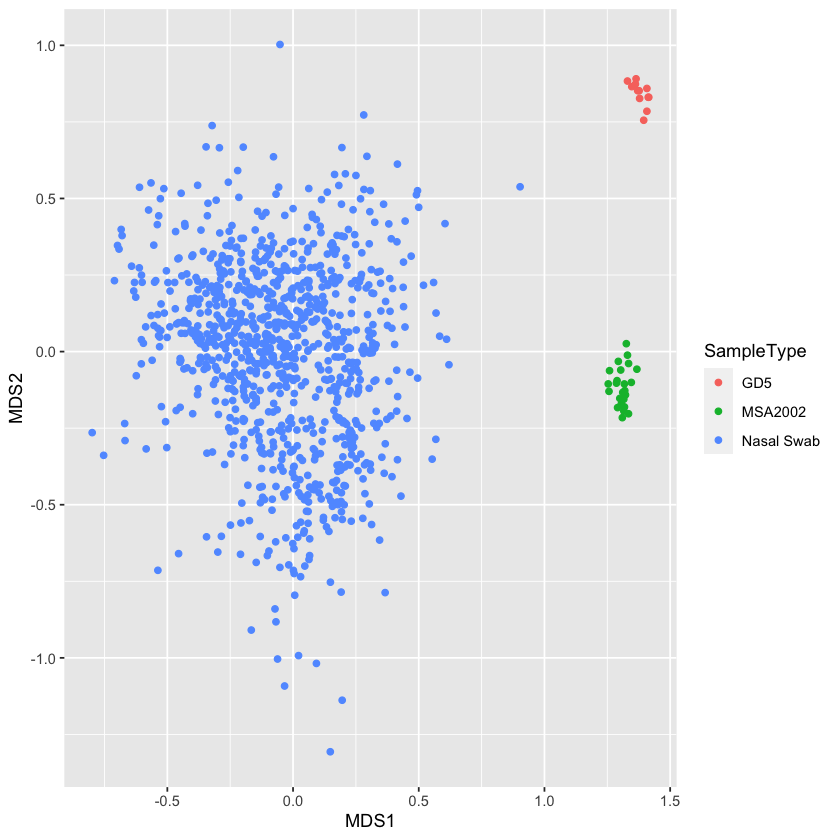

In [10]:
otu_nmds_all_sample_type = ggplot(nmds_w_meta, aes(x=MDS1, y=MDS2, col=SampleType)) + geom_point()
otu_nmds_all_sample_type
ggsave("../../figures/otu_nmds_all_sample_type.pdf", otu_nmds_all_sample_type, dpi=300)

Warning message:
“Removed 64 rows containing missing values (`geom_point()`).”


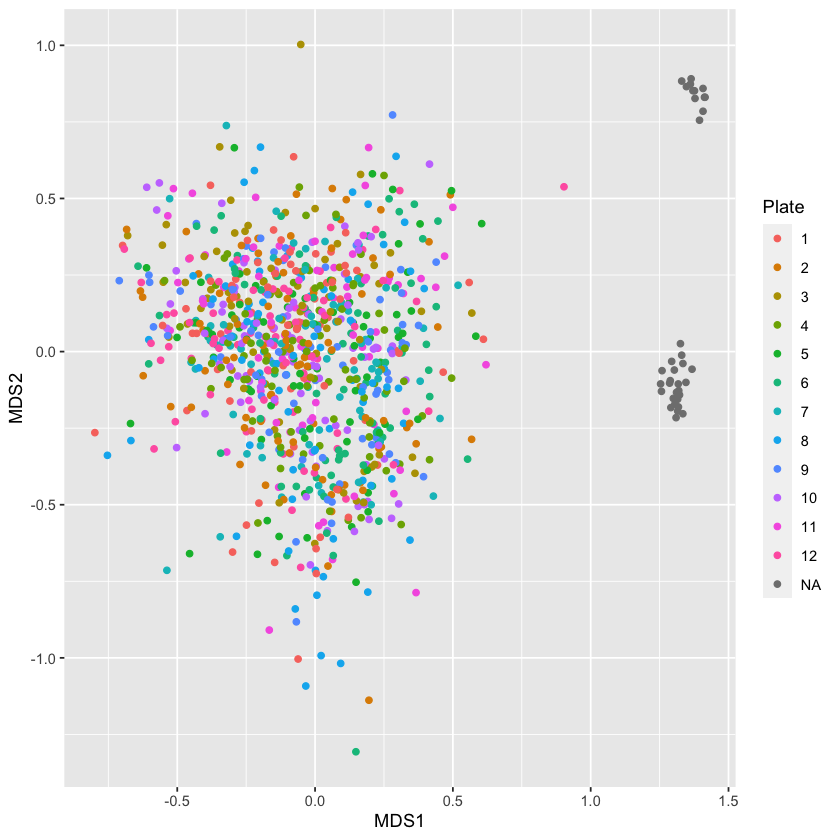

In [11]:
ggplot(nmds_w_meta, aes(x=MDS1, y=MDS2, col=Plate)) + geom_point()

Clear grouping by sample type. The GD5 (control stool samples) and the MSA20002 samples cluster clearly away from the rest of the samples. We can't see plate 8 jumping far away from the rest of the plates which is nice.

## NMDS of controls only

The commented out lines here are to do the analysis by refiltering and rerarefying the data. This is because our filters may remove OTUs which are specific to the controls since there are many more test samples than control samples. In practice it doesn't seem to make a difference. The code is left here so someone could replicate this analysis.

In [12]:
control_samples = sapply(row.names(abunds_gt10_rar10K), function(x) (startsWith(x, 'GD5') | startsWith(x, 'MSA2002')))
abunds_controls_gt10_rar10K = abunds_gt10_rar10K[control_samples,]
head(abunds_controls_gt10_rar10K)

Otu0001 Otu0002 Otu0003 Otu0004 Otu0005 Otu0006 Otu0007 Otu0008 Otu0009
GD5_1  1       0       0       1       1       1       0       0       1      
GD5_10 0       0       0       0       0       0       0       0       0      
GD5_11 6       0       1       0       3       1       0       1       1      
GD5_12 0       1       1       0       1       0       0       0       1      
GD5_2  0       0       2       0       1       0       0       0       1      
GD5_3  1       1       0       0       0       0       0       0       0      
       Otu0010 ⋯ Otu2849 Otu2850 Otu2851 Otu2853 Otu2854 Otu2855 Otu2856
GD5_1  0       ⋯ 0       0       0       0       0       0       0      
GD5_10 0       ⋯ 0       0       0       0       0       0       0      
GD5_11 0       ⋯ 0       0       0       0       0       0       0      
GD5_12 0       ⋯ 0       0       0       0       0       1       0      
GD5_2  0       ⋯ 0       0       0       0       0       0       0      
GD5_3  0       ⋯ 0       0       0       0       0       0       0      
       Otu2857 Otu2858 Otu2859
GD5_1  0       0       0      
GD5_10 0       0       0      
GD5_11 0       0       0      
GD5_12 0       0       0      
GD5_2  0       0       0      
GD5_3  0       0       0

In [13]:
nmds_controls = metaMDS(abunds_controls_gt10_rar10K, k=2)

Square root transformation
Wisconsin double standardization
Run 0 stress 8.545434e-05 
Run 1 stress 8.588545e-05 
... Procrustes: rmse 4.161581e-05  max resid 7.770013e-05 
... Similar to previous best
Run 2 stress 7.041579e-05 
... New best solution
... Procrustes: rmse 3.602862e-05  max resid 7.969771e-05 
... Similar to previous best
Run 3 stress 8.75552e-05 
... Procrustes: rmse 4.312245e-05  max resid 0.0001055636 
... Similar to previous best
Run 4 stress 8.018617e-05 
... Procrustes: rmse 3.67918e-05  max resid 8.896918e-05 
... Similar to previous best
Run 5 stress 7.742974e-05 
... Procrustes: rmse 3.86423e-05  max resid 9.012422e-05 
... Similar to previous best
Run 6 stress 9.982322e-05 
... Procrustes: rmse 4.879319e-05  max resid 0.0001405218 
... Similar to previous best
Run 7 stress 5.321237e-05 
... New best solution
... Procrustes: rmse 3.595102e-05  max resid 9.390665e-05 
... Similar to previous best
Run 8 stress 9.959717e-05 
... Procrustes: rmse 4.136166e-05  max r

Warning message in metaMDS(abunds_controls_gt10_rar10K, k = 2):
“stress is (nearly) zero: you may have insufficient data”


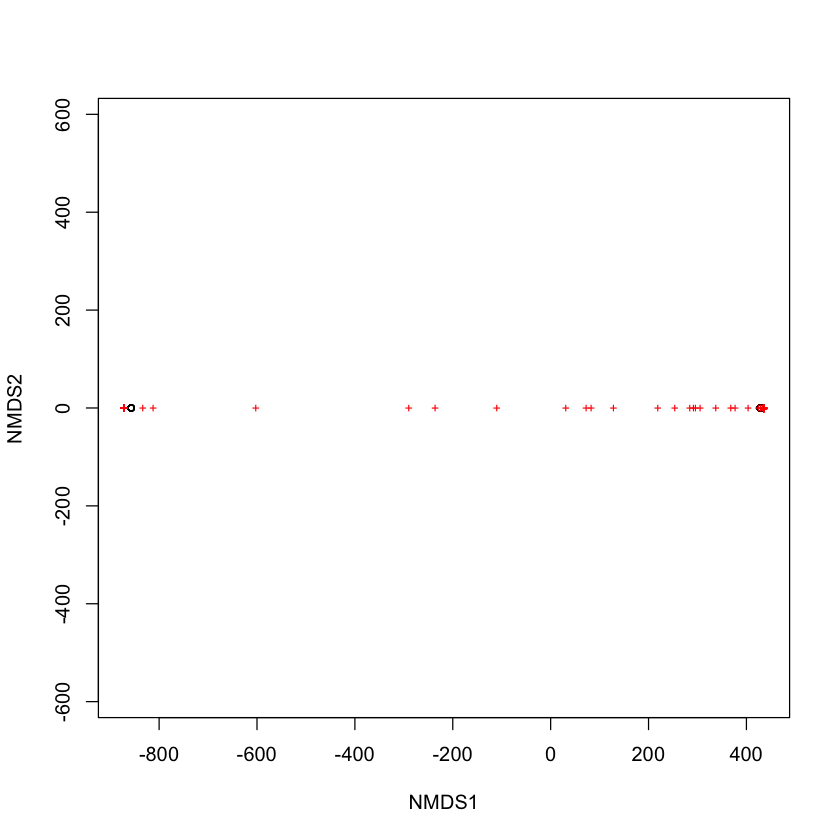

In [14]:
plot(nmds_controls)

In [15]:
nmds_controls_points = as_tibble(nmds_controls$points, rownames='SampleID')
write_csv(nmds_controls_points, '../../data/nasal/otu_nmds_controls.csv')
controls_only = nmds_controls_points %>% 
                    separate(SampleID, c('SampleType', 'plate'), remove=F, extra='drop')
head(controls_only)

SampleID SampleType plate MDS1      MDS2       
1 GD5_1    GD5        1     -856.9898 -0.01371539
2 GD5_10   GD5        10    -857.0289 -0.03214250
3 GD5_11   GD5        11    -856.9834  0.03193419
4 GD5_12   GD5        12    -857.1003  0.01842145
5 GD5_2    GD5        2     -857.0809  0.05342753
6 GD5_3    GD5        3     -857.0931  0.02003714

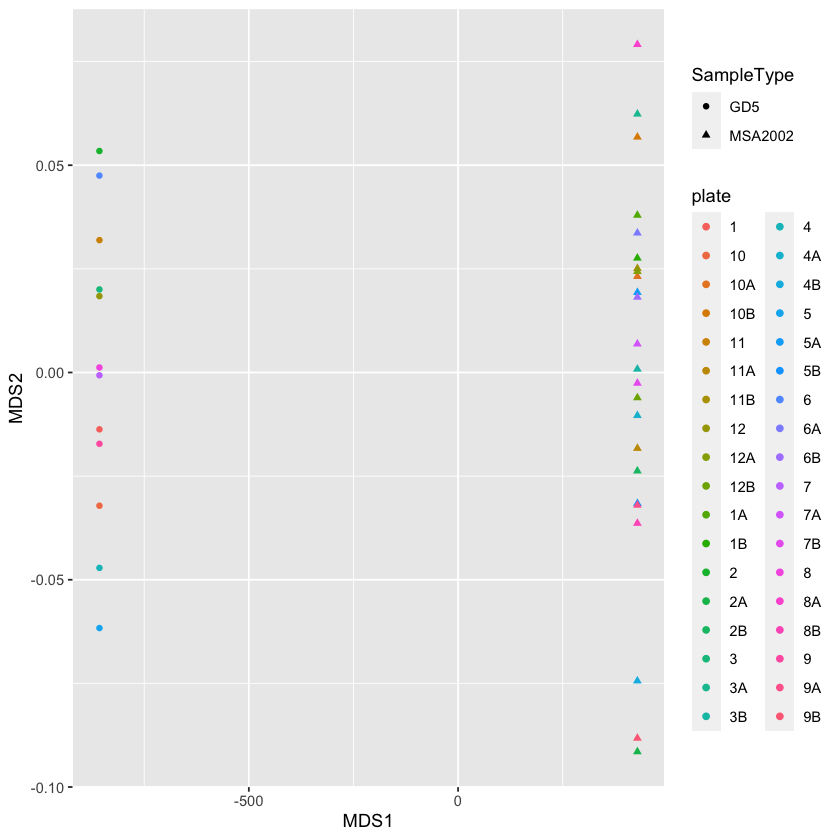

In [16]:
ggplot(controls_only, aes(x=MDS1, y=MDS2, shape=SampleType, col=plate)) + geom_point()

GD5 and MSA2002 clearly cluster separately from each other. Plate 8 isn't at the extreme of either side.

## NMDS baby samples separately

Now we will look at the real data. Again commented out code is for filtering and rarefying specifically on the babies data and it had not significant effect on the results.

In [17]:
baby_samples = sapply(row.names(abunds_gt10_rar10K), function(x) (!startsWith(x, 'GD5') & !startsWith(x, 'MSA2002')))
abunds_babies_gt10_rar10K = abunds_gt10_rar10K[baby_samples,]
tail(abunds_babies_gt10_rar10K)

Otu0001 Otu0002 Otu0003 Otu0004 Otu0005 Otu0006 Otu0007 Otu0008
265_V4_NS_A1  1      327      629       0    0          0      8     6310   
265_V5_NS_A1 45       20     1283       0    0          0    465     1884   
265_V6_NS_A1  0      731     2703       0    0          0     10      719   
265_V7_NS_A1  3      117      418    5896    1       2822      0       62   
265_V8_NS_A1  3       70      640    3815    1       3826     18       32   
265_V9_NS_A1  3       65      667    1169    0       4393     44      127   
             Otu0009 Otu0010 ⋯ Otu2849 Otu2850 Otu2851 Otu2853 Otu2854 Otu2855
265_V4_NS_A1  708    0       ⋯ 0       0       0       0       0       0      
265_V5_NS_A1 3113    0       ⋯ 0       0       0       0       0       0      
265_V6_NS_A1 1189    0       ⋯ 0       0       0       0       0       0      
265_V7_NS_A1  102    1       ⋯ 0       0       0       0       0       0      
265_V8_NS_A1  120    0       ⋯ 0       0       0       0       0       0      
265_V9_NS_A1   88    0       ⋯ 0       0       0       0       0       0      
             Otu2856 Otu2857 Otu2858 Otu2859
265_V4_NS_A1 0       0       0       0      
265_V5_NS_A1 0       0       0       0      
265_V6_NS_A1 0       0       0       0      
265_V7_NS_A1 0       0       0       0      
265_V8_NS_A1 0       0       0       0      
265_V9_NS_A1 0       0       0       0

In [18]:
nmds_babies = metaMDS(abunds_babies_gt10_rar10K, k=3)

Square root transformation
Wisconsin double standardization
Run 0 stress 0.1822181 
Run 1 stress 0.1837356 
Run 2 stress 0.182719 
Run 3 stress 0.1830982 
Run 4 stress 0.181978 
... New best solution
... Procrustes: rmse 0.004788953  max resid 0.06816383 
Run 5 stress 0.183346 
Run 6 stress 0.1821541 
... Procrustes: rmse 0.003987121  max resid 0.06806199 
Run 7 stress 0.1830107 
Run 8 stress 0.1829 
Run 9 stress 0.1823232 
... Procrustes: rmse 0.006181754  max resid 0.09453212 
Run 10 stress 0.1820751 
... Procrustes: rmse 0.003548323  max resid 0.0682806 
Run 11 stress 0.1828942 
Run 12 stress 0.1919696 
Run 13 stress 0.1822571 
... Procrustes: rmse 0.003556011  max resid 0.05570745 
Run 14 stress 0.1824978 
Run 15 stress 0.1821281 
... Procrustes: rmse 0.004069873  max resid 0.0682826 
Run 16 stress 0.1822628 
... Procrustes: rmse 0.00663262  max resid 0.09446611 
Run 17 stress 0.182761 
Run 18 stress 0.1827656 
Run 19 stress 0.1822292 
... Procrustes: rmse 0.004932528  max resid 0.

In [19]:
nmds_babies$stress

[1] 0.181978

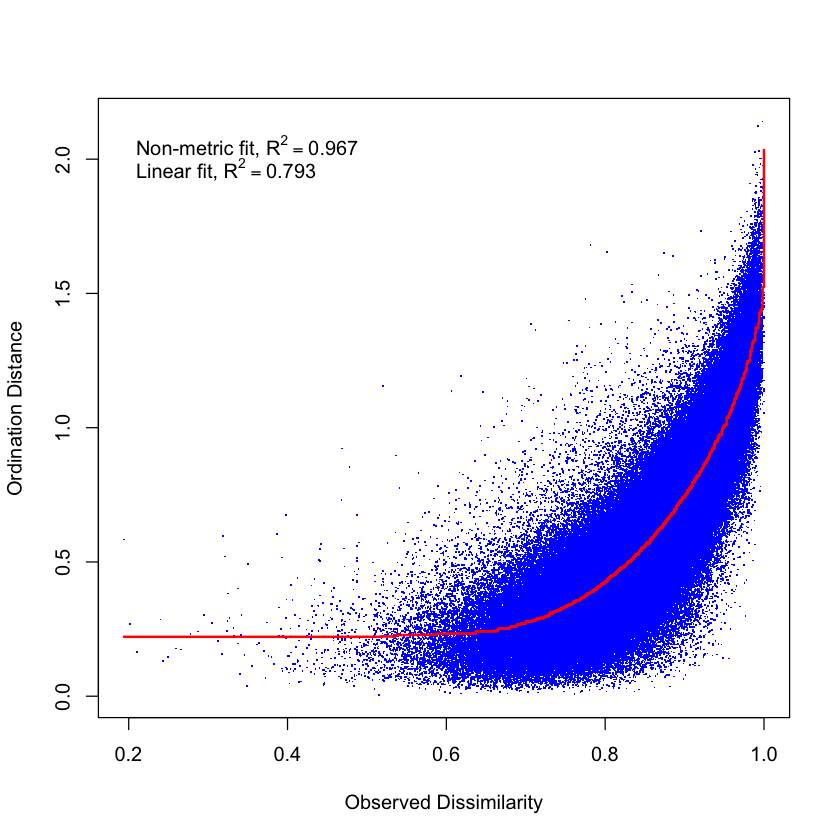

In [20]:
stressplot(nmds_babies)

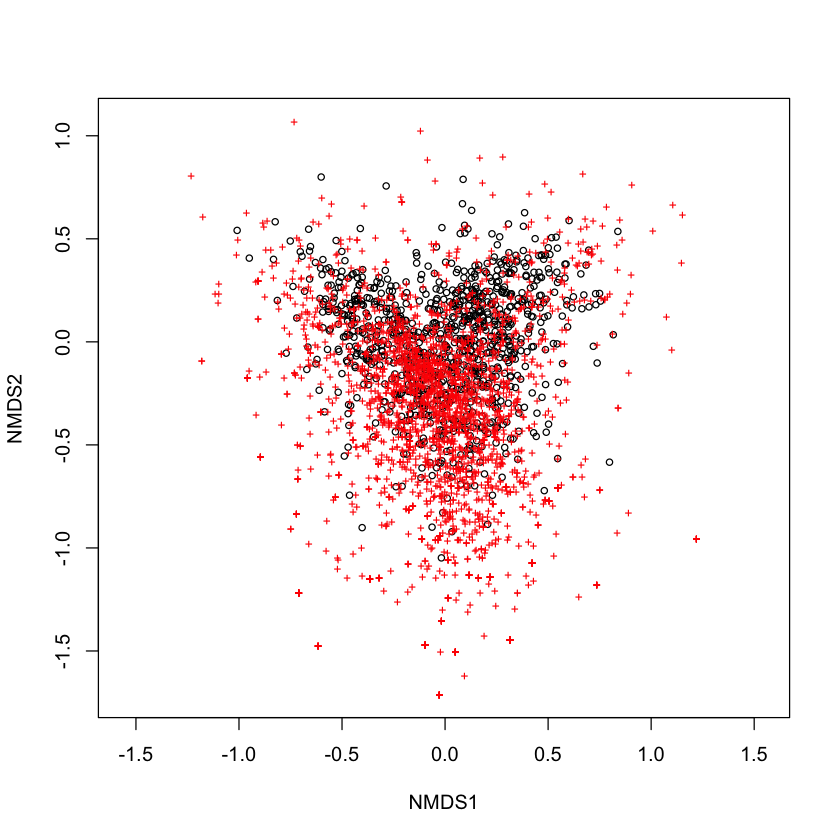

In [21]:
plot(nmds_babies)

In [22]:
nmds_babies_points = as_tibble(nmds_babies$points, rownames='SampleID')
write_csv(nmds_babies_points, '../../data/nasal/otu_nmds_babies.csv')
baby_samples_only = left_join(meta, nmds_babies_points, by='SampleID')
head(baby_samples_only)

SubmissionType  SampleNumber SampleID     SampleIDValidation
1 Primary in Tube 1            103_V5_NS_A1 NA                
2 Primary in Tube 2            106_V5_NS_A1 NA                
3 Primary in Tube 3            107_V2_NS_A1 NA                
4 Primary in Tube 4            107_V3_NS_A1 NA                
5 Primary in Tube 5            107_V5_NS_A1 NA                
6 Primary in Tube 6            108_V4_NS_A1 NA                
  DiversigenCheckInSampleName ReplacesLowVolumeSampleID BoxLocation SampleType
1 NA                          NA                        Box 1, A1   Nasal Swab
2 NA                          NA                        Box 1, A3   Nasal Swab
3 NA                          NA                        Box 1, A4   Nasal Swab
4 107_V8_NS_A1                NA                        Box 1, A5   Nasal Swab
5 NA                          NA                        Box 1, A8   Nasal Swab
6 NA                          NA                        Box 1, A9   Nasal Swab
  SampleSource SequencingType ⋯ PT_protected Dip_protected FHA_protected
1 Human Infant 16             ⋯    NA           NA            NA        
2 Human Infant 16             ⋯ FALSE         TRUE          TRUE        
3 Human Infant 16             ⋯ FALSE         TRUE         FALSE        
4 Human Infant 16             ⋯ FALSE         TRUE         FALSE        
5 Human Infant 16             ⋯ FALSE         TRUE         FALSE        
6 Human Infant 16             ⋯ FALSE        FALSE         FALSE        
  PRN_protected TET_protected PRP (Hib)_protected VR_group MDS1       
1    NA            NA           NA                NA        0.03639039
2 FALSE          TRUE         TRUE                NVR      -0.34217669
3  TRUE          TRUE         TRUE                NVR               NA
4  TRUE          TRUE         TRUE                NVR               NA
5  TRUE          TRUE         TRUE                NVR      -0.36302600
6 FALSE         FALSE         TRUE                LVR      -0.50062195
  MDS2      MDS3       
1 0.2512785 -0.26573145
2 0.1823141  0.43417099
3        NA          NA
4        NA          NA
5 0.2626840 -0.08780502
6 0.3426146 -0.11854216

Warning message:
“Removed 64 rows containing missing values (`geom_point()`).”


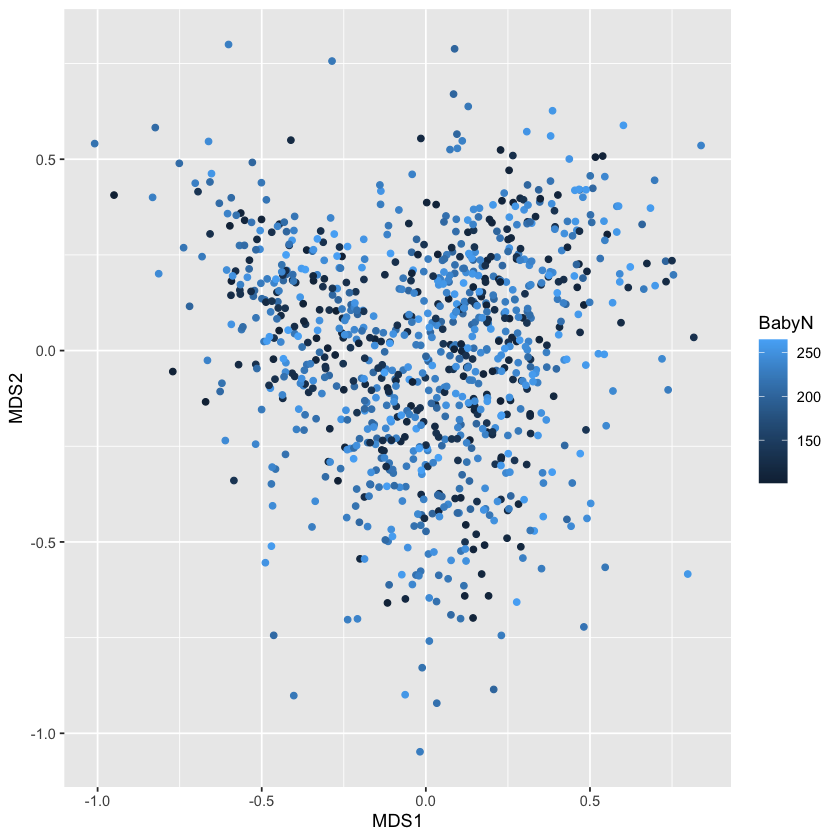

In [23]:
ggplot(baby_samples_only, aes(x=MDS1, y=MDS2, col=BabyN)) + geom_point()

No clear clustering by baby.

Warning message:
“Removed 64 rows containing missing values (`geom_point()`).”
Saving 7 x 7 in image
Warning message:
“Removed 64 rows containing missing values (`geom_point()`).”


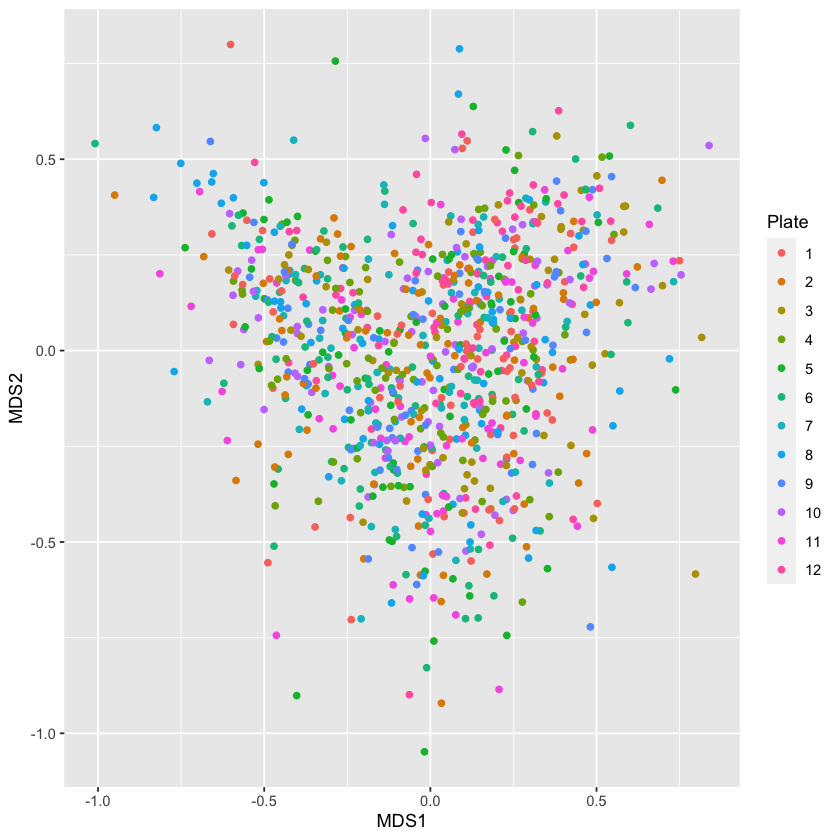

In [24]:
otu_nmds_plate = ggplot(baby_samples_only, aes(x=MDS1, y=MDS2, col=Plate)) + geom_point()
otu_nmds_plate
ggsave("../../figures/otu_nmds_plate.pdf", otu_nmds_plate, dpi=300)

No clear clustering by plate.

Warning message:
“Removed 64 rows containing missing values (`geom_point()`).”


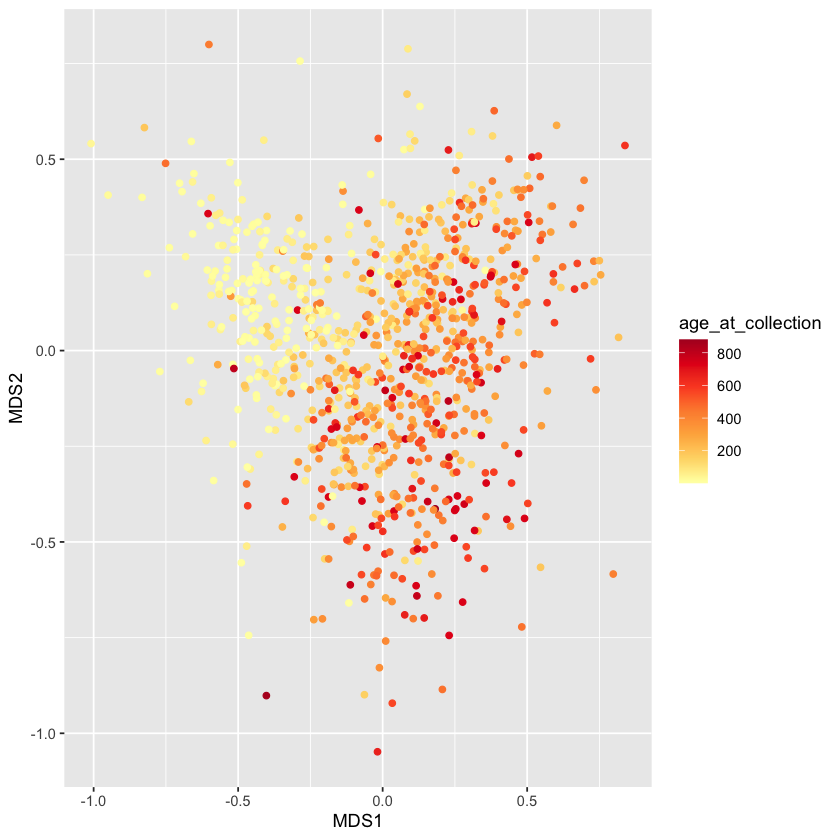

In [25]:
# ggplot(baby_samples_only, aes(x=MDS1, y=MDS2)) + geom_point(aes(color=age_at_collection)) + scale_color_gradient(low='yellow', high='red')
ggplot(baby_samples_only, aes(x=MDS1, y=MDS2)) + geom_point(aes(color=age_at_collection)) + scale_color_distiller(palette = 'YlOrRd', direction = 1)

Clear clustering by age. Young samples are on the left side of the plot and older babies are on the left. Young samples look more similar to each other than older samples. Aging of the microbiome seems to stall out at around 1 year which is probably when all babies have been weaned and developed more adult diets.

In [26]:
summary(lm(MDS1 ~ age_at_collection, baby_samples_only))


Call:
lm(formula = MDS1 ~ age_at_collection, data = baby_samples_only)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.94386 -0.19597 -0.00102  0.17735  0.88085 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)       -2.156e-01  1.429e-02  -15.09   <2e-16 ***
age_at_collection  7.629e-04  3.999e-05   19.08   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2687 on 942 degrees of freedom
  (64 observations deleted due to missingness)
Multiple R-squared:  0.2787,	Adjusted R-squared:  0.2779 
F-statistic:   364 on 1 and 942 DF,  p-value: < 2.2e-16


Warning message:
“Removed 64 rows containing missing values (`geom_point()`).”


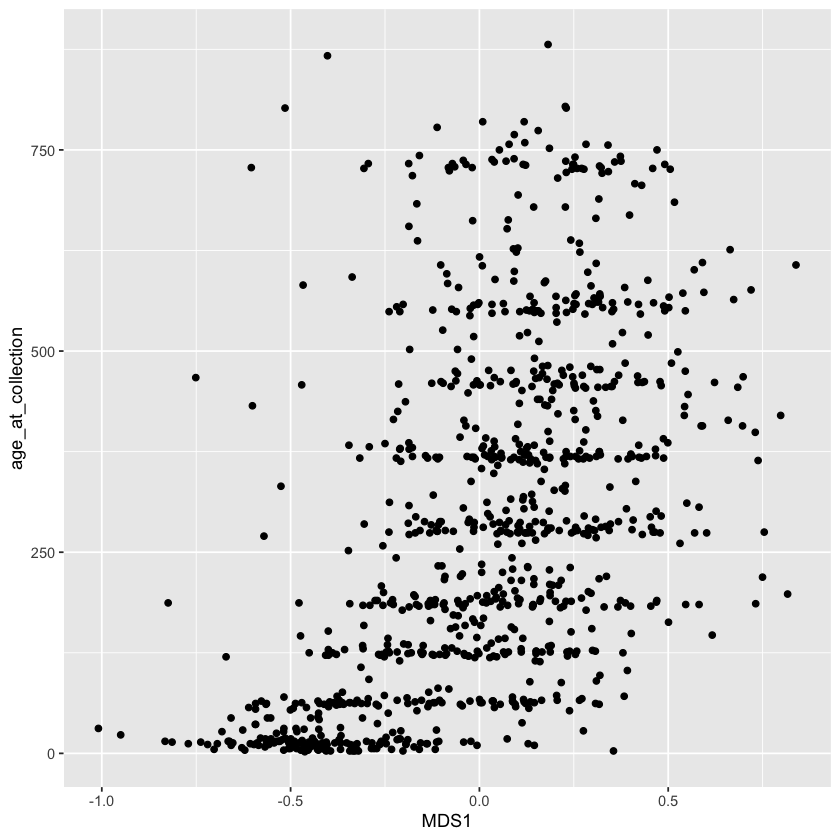

In [27]:
ggplot(baby_samples_only, aes(x=MDS1, y=age_at_collection)) + geom_point()

We can see a significant correlation between MDS1 value and age and see in the plot. The correlation seems like it would be most strong diagonally across MDS1 and MDS2.

### Inter vs. intra baby distance

This is to check for significance differences in distance between points from within or between groups. We can use this to look for plate effects and baby effects.

In [28]:
baby_bray_dists = tidy(vegdist(abunds_babies_gt10_rar10K, 'bray'))

baby_bray_dists = baby_bray_dists %>% left_join((meta %>% select(c("SampleID", "Plate"))), by=c('item1' = 'SampleID')) %>% rename(plate1 = Plate) %>%
                                      left_join((meta %>% select(c("SampleID", "Plate"))), by=c('item2' = 'SampleID')) %>% rename(plate2 = Plate) %>%
                                      mutate(same_plate = plate1 == plate2) %>%
                                      left_join((meta %>% select(c("SampleID", "BabyN"))), by=c('item1' = 'SampleID')) %>% rename(baby1 = BabyN) %>%
                                      left_join((meta %>% select(c("SampleID", "BabyN"))), by=c('item2' = 'SampleID')) %>% rename(baby2 = BabyN) %>%
                                      mutate(same_baby = baby1 == baby2) %>%
                                      left_join((meta %>% select(c("SampleID", "age_at_collection"))), by=c('item1' = 'SampleID')) %>% rename(age1 = age_at_collection) %>%
                                      left_join((meta %>% select(c("SampleID", "age_at_collection"))), by=c('item2' = 'SampleID')) %>% rename(age2 = age_at_collection) %>%
                                      mutate(age_diff = abs(age1 - age2))
head(baby_bray_dists)

item1        item2        distance plate1 plate2 same_plate baby1 baby2
1 101_S1_NS_A1 101_V3_NS_A1 0.4101   2      2       TRUE      101   101  
2 101_S1_NS_A1 101_V5_NS_A1 0.5277   2      2       TRUE      101   101  
3 101_S1_NS_A1 102_V1_NS_A1 0.9144   2      7      FALSE      101   102  
4 101_S1_NS_A1 102_V3_NS_A1 0.8985   2      7      FALSE      101   102  
5 101_S1_NS_A1 102_V5_NS_A1 0.9223   2      7      FALSE      101   102  
6 101_S1_NS_A1 102_V6_NS_A1 0.3357   2      7      FALSE      101   102  
  same_baby age1 age2 age_diff
1  TRUE     44    23  21      
2  TRUE     44    61  17      
3 FALSE     44     6  38      
4 FALSE     44    15  29      
5 FALSE     44    59  15      
6 FALSE     44   120  76

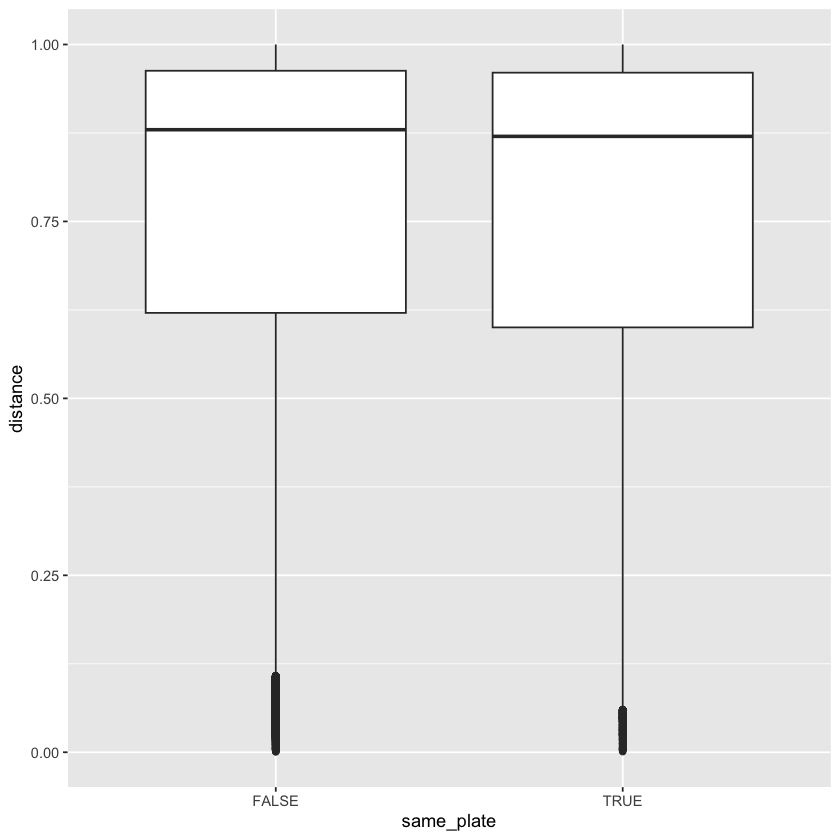

In [29]:
baby_bray_dists %>% ggplot(aes(same_plate, distance)) + geom_boxplot()

Very similar values between and within plates.

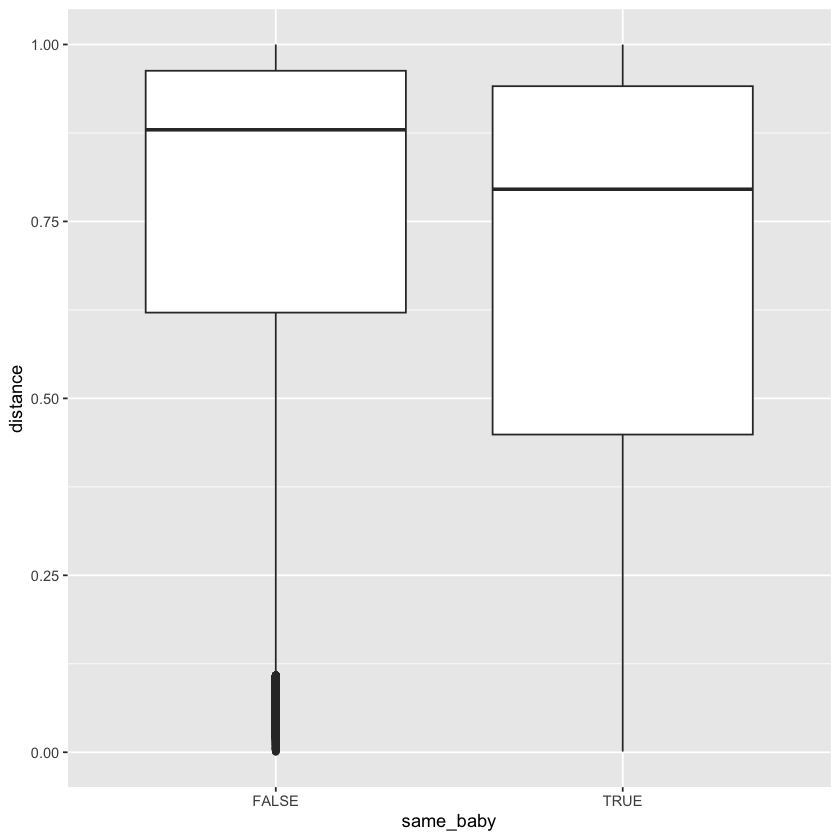

In [30]:
baby_bray_dists %>% ggplot(aes(same_baby, distance)) + geom_boxplot()

There is a difference in within baby and between baby comparisons. Samples from the same baby are much more similar than samples from different babies.

### Swab type coloring

Swab codes are explained in https://stash.merck.com/projects/VACM/repos/imc_interim_analysis/browse/README.md

Warning message:
“Removed 64 rows containing missing values (`geom_point()`).”
Saving 7 x 7 in image
Warning message:
“Removed 64 rows containing missing values (`geom_point()`).”


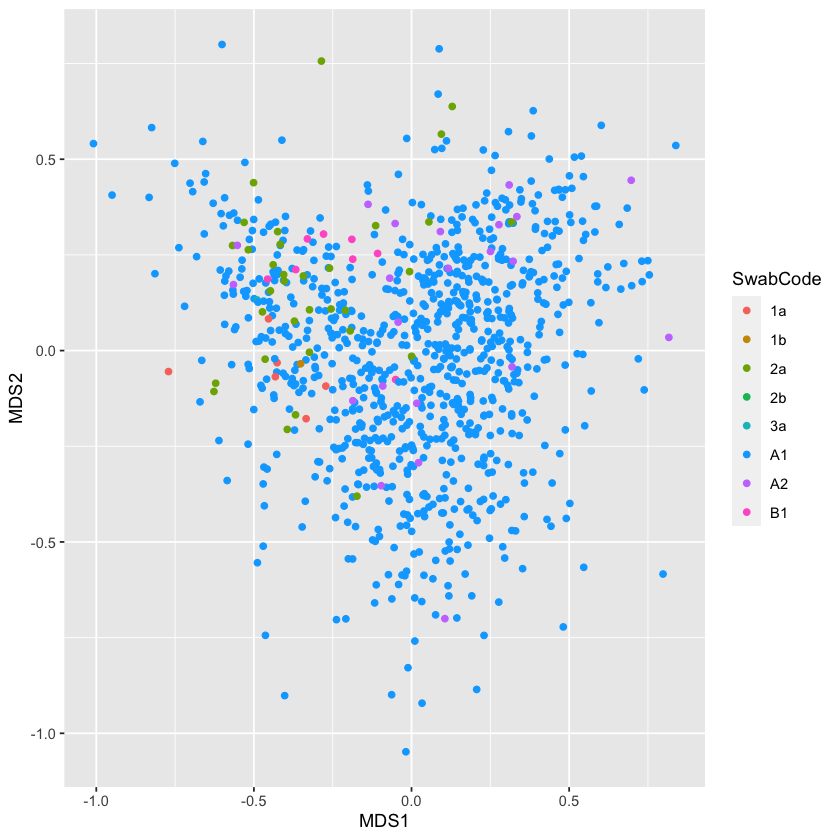

In [31]:
otu_nmds_swab = ggplot(baby_samples_only, aes(x=MDS1, y=MDS2)) + geom_point(aes(color=SwabCode))
otu_nmds_swab
ggsave("../../figures/otu_nmds_swab.pdf", otu_nmds_swab, dpi=300)

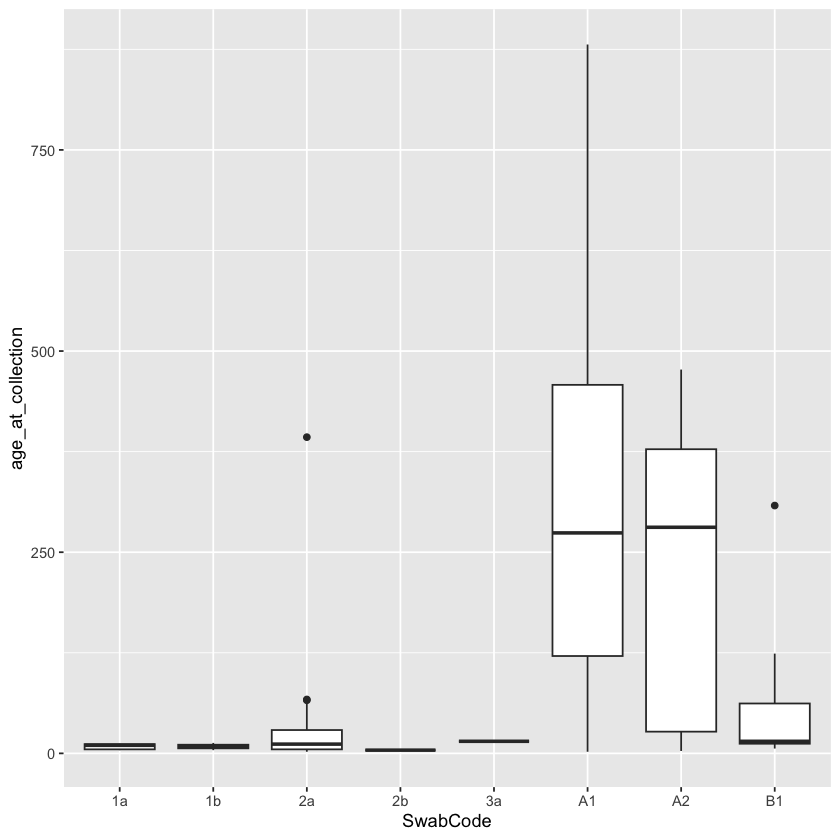

In [32]:
baby_samples_only %>% ggplot(aes(x=SwabCode, y=age_at_collection)) + geom_boxplot()

In [33]:
baby_bray_dists %>% head()

item1        item2        distance plate1 plate2 same_plate baby1 baby2
1 101_S1_NS_A1 101_V3_NS_A1 0.4101   2      2       TRUE      101   101  
2 101_S1_NS_A1 101_V5_NS_A1 0.5277   2      2       TRUE      101   101  
3 101_S1_NS_A1 102_V1_NS_A1 0.9144   2      7      FALSE      101   102  
4 101_S1_NS_A1 102_V3_NS_A1 0.8985   2      7      FALSE      101   102  
5 101_S1_NS_A1 102_V5_NS_A1 0.9223   2      7      FALSE      101   102  
6 101_S1_NS_A1 102_V6_NS_A1 0.3357   2      7      FALSE      101   102  
  same_baby age1 age2 age_diff
1  TRUE     44    23  21      
2  TRUE     44    61  17      
3 FALSE     44     6  38      
4 FALSE     44    15  29      
5 FALSE     44    59  15      
6 FALSE     44   120  76

Warning message:
“Removed 64 rows containing missing values (`geom_point()`).”


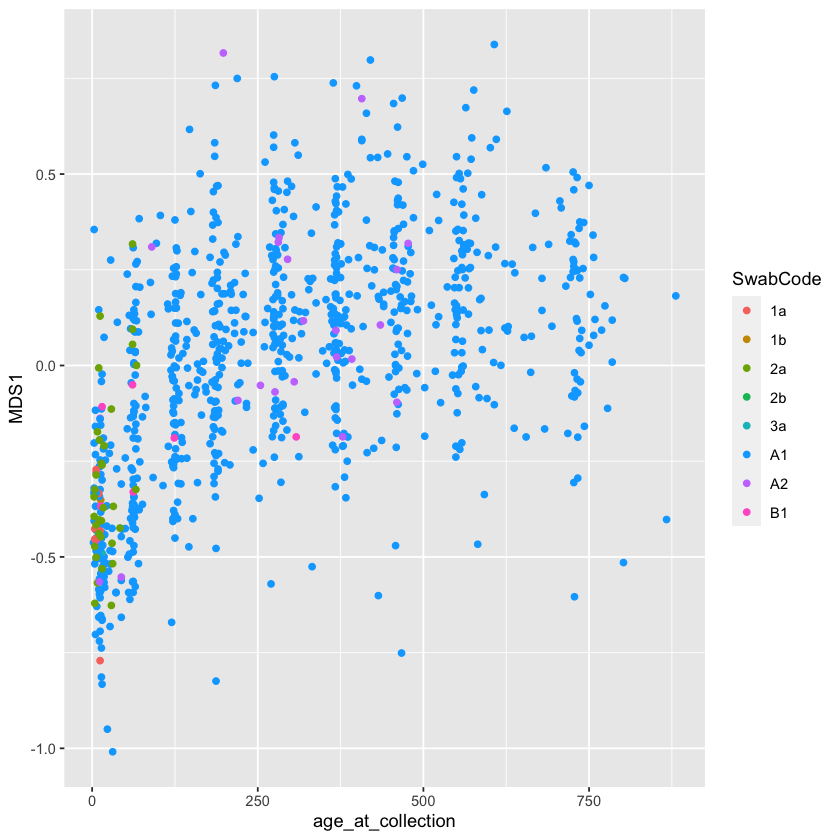

In [34]:
ggplot(baby_samples_only, aes(x=age_at_collection, y=MDS1)) + geom_point(aes(color=SwabCode))

Warning message:
“Removed 64 rows containing missing values (`geom_point()`).”


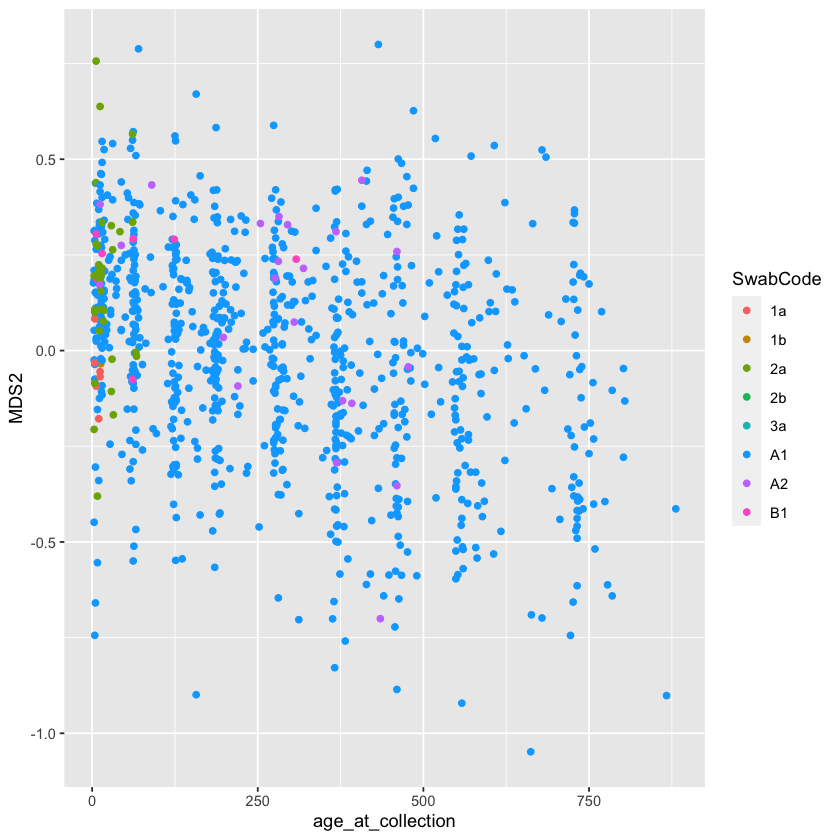

In [35]:
ggplot(baby_samples_only, aes(x=age_at_collection, y=MDS2)) + geom_point(aes(color=SwabCode))

It's hard to interpret the results per swab. Most are concentrated to the first time points. I don't think it's something we need to worry about.

## Abx

Now look at the effect of antibiotics on the NMDS plots.

Warning message:
“Removed 64 rows containing missing values (`geom_point()`).”


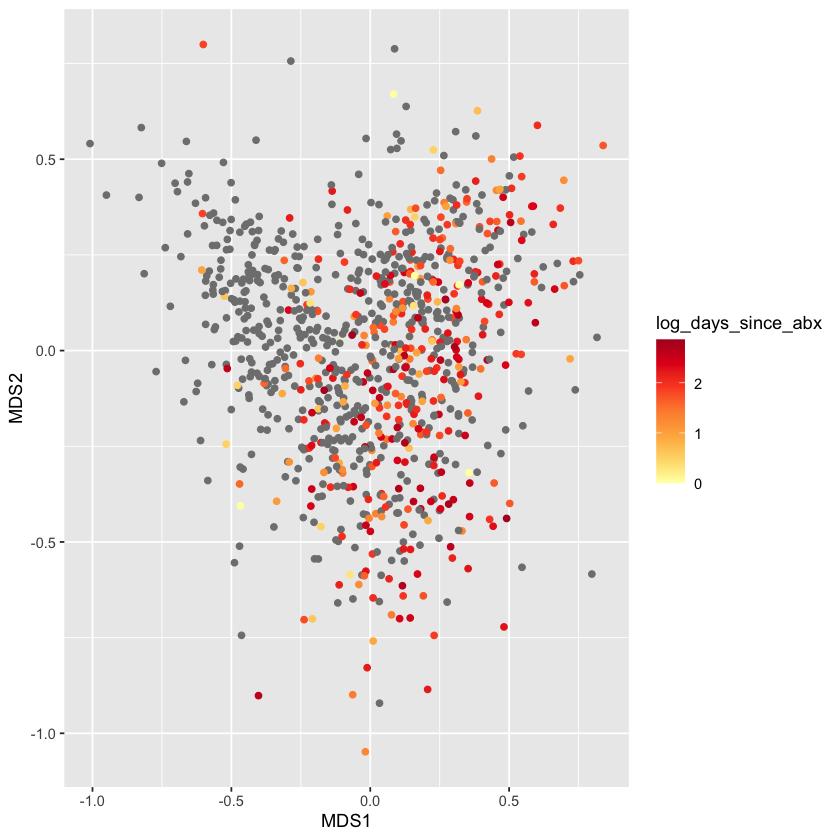

In [36]:
baby_samples_only %>% mutate(log_days_since_abx = log10(days_since_abx_end)) %>% ggplot(aes(x=MDS1, y=MDS2, color=log_days_since_abx)) + geom_point() + scale_color_distiller(palette = 'YlOrRd', direction = 1)

No clear jumps. We would hope to see the light colored dots moving up and to the left. Lots that stay within the adult looking dots zone.

Warning message:
“Removed 64 rows containing missing values (`geom_point()`).”


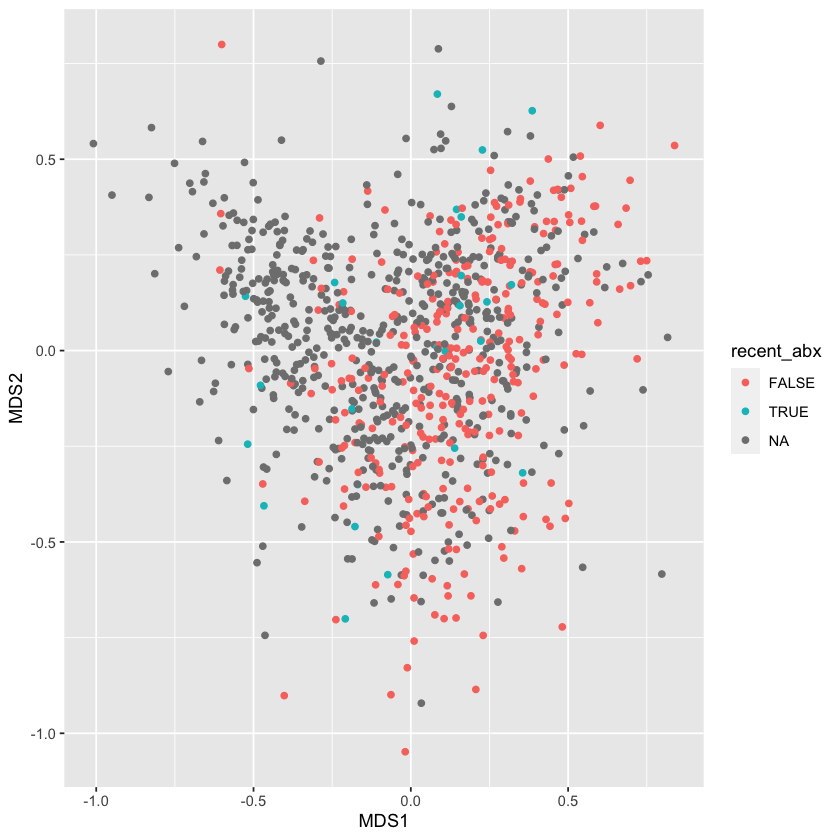

In [37]:
baby_samples_only %>% mutate(recent_abx = days_since_abx_end < 7) %>% ggplot(aes(x=MDS1, y=MDS2, color=recent_abx)) + geom_point()

Still no pattern if we only look at recent antibiotics samples.

## Titers

Warning message:
“Removed 64 rows containing missing values (`geom_point()`).”


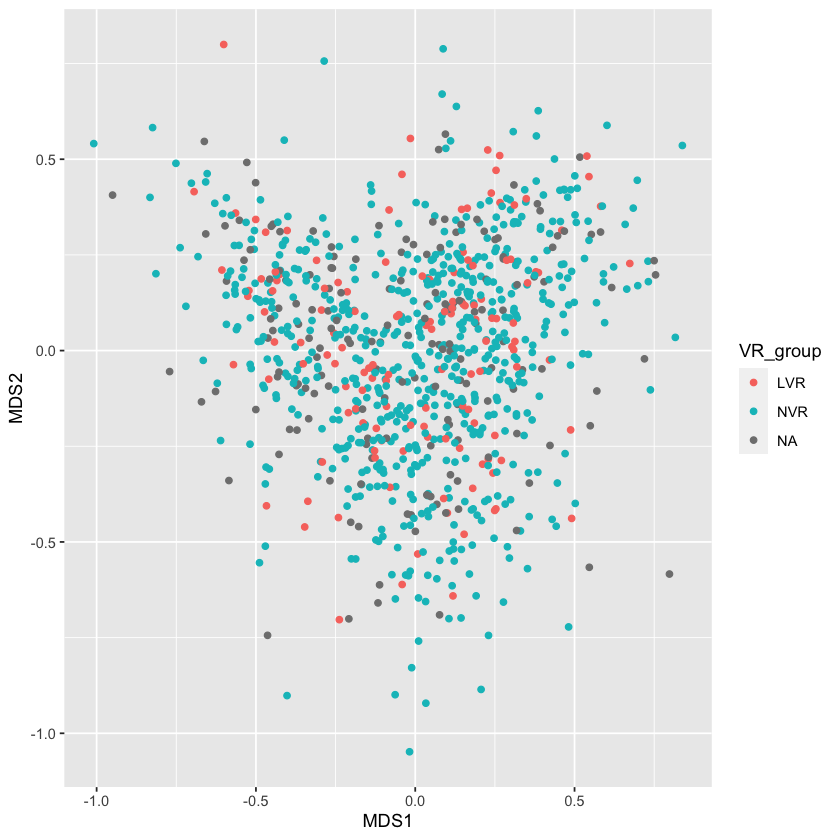

In [38]:
baby_samples_only %>% ggplot(aes(x=MDS1, y=MDS2, color=VR_group)) + geom_point()

No clustering by VR group.

Warning message:
“Using alpha for a discrete variable is not advised.”
Warning message:
“Removed 64 rows containing missing values (`geom_point()`).”
Warning message:
“Using alpha for a discrete variable is not advised.”
Warning message:
“Removed 64 rows containing missing values (`geom_point()`).”
Warning message:
“Using alpha for a discrete variable is not advised.”
Warning message:
“Removed 64 rows containing missing values (`geom_point()`).”
Warning message:
“Using alpha for a discrete variable is not advised.”
Warning message:
“Removed 64 rows containing missing values (`geom_point()`).”


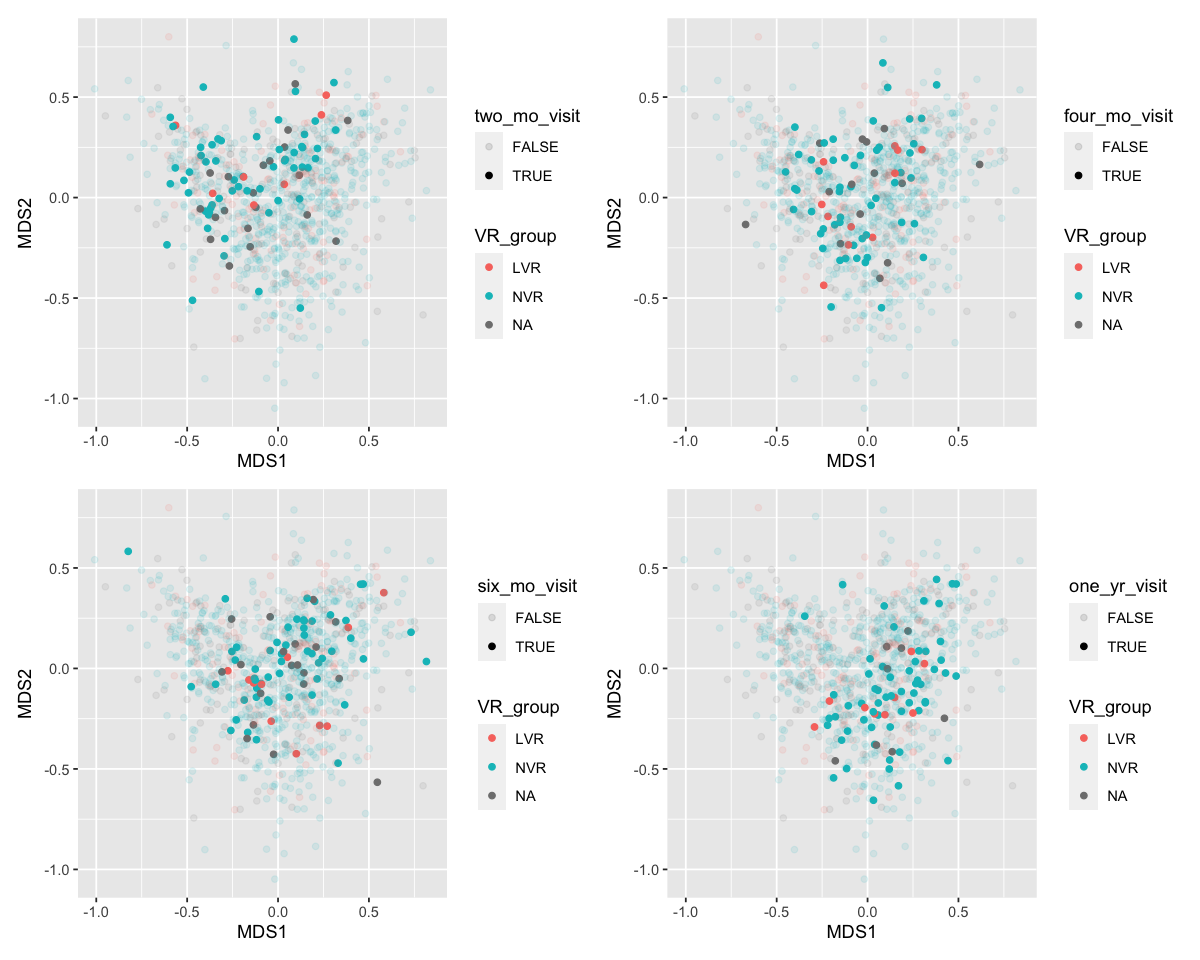

In [39]:
vr_two_month_plot = baby_samples_only %>% mutate('two_mo_visit' = VisitCode == 'V5') %>% ggplot(aes(x=MDS1, y=MDS2, color=VR_group, alpha=two_mo_visit)) + geom_point()
vr_four_month_plot = baby_samples_only %>% mutate('four_mo_visit' = VisitCode == 'V6') %>% ggplot(aes(x=MDS1, y=MDS2, color=VR_group, alpha=four_mo_visit)) + geom_point()
vr_six_month_plot = baby_samples_only %>% mutate('six_mo_visit' = VisitCode == 'V7') %>% ggplot(aes(x=MDS1, y=MDS2, color=VR_group, alpha=six_mo_visit)) + geom_point()
vr_one_year_plot = baby_samples_only %>% mutate('one_yr_visit' = VisitCode == 'V9') %>% ggplot(aes(x=MDS1, y=MDS2, color=VR_group, alpha=one_yr_visit)) + geom_point()
options(repr.plot.width = 10, repr.plot.height = 8)
vr_two_month_plot + vr_four_month_plot + vr_six_month_plot + vr_one_year_plot

Warning message:
“Removed 64 rows containing missing values (`geom_point()`).”


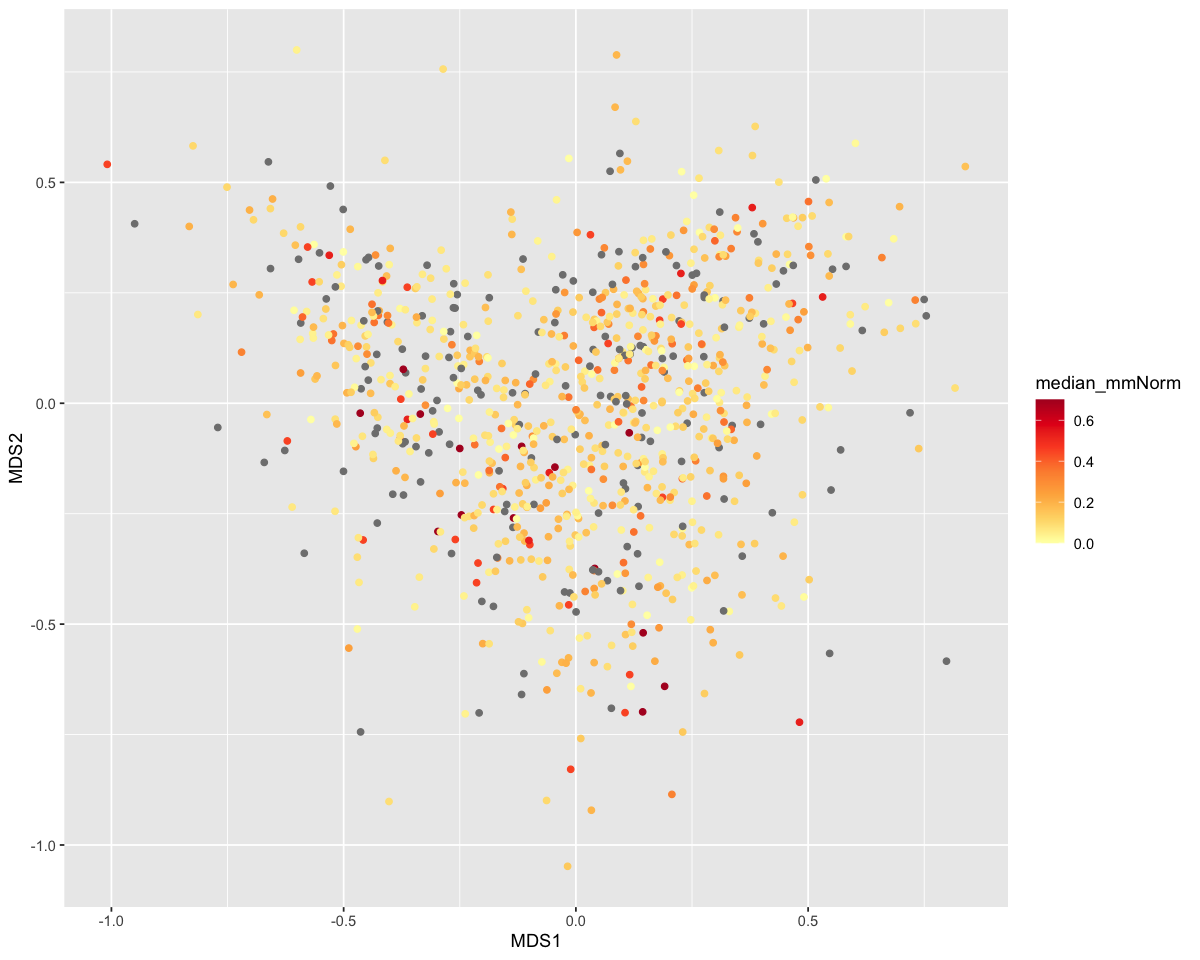

In [40]:
baby_samples_only %>% ggplot(aes(x=MDS1, y=MDS2, color=median_mmNorm)) + geom_point() + scale_color_distiller(palette = 'YlOrRd', direction = 1)

Warning message:
“Using alpha for a discrete variable is not advised.”
Warning message:
“Removed 64 rows containing missing values (`geom_point()`).”
Warning message:
“Using alpha for a discrete variable is not advised.”
Warning message:
“Removed 64 rows containing missing values (`geom_point()`).”
Warning message:
“Using alpha for a discrete variable is not advised.”
Warning message:
“Removed 64 rows containing missing values (`geom_point()`).”
Warning message:
“Using alpha for a discrete variable is not advised.”
Warning message:
“Removed 64 rows containing missing values (`geom_point()`).”


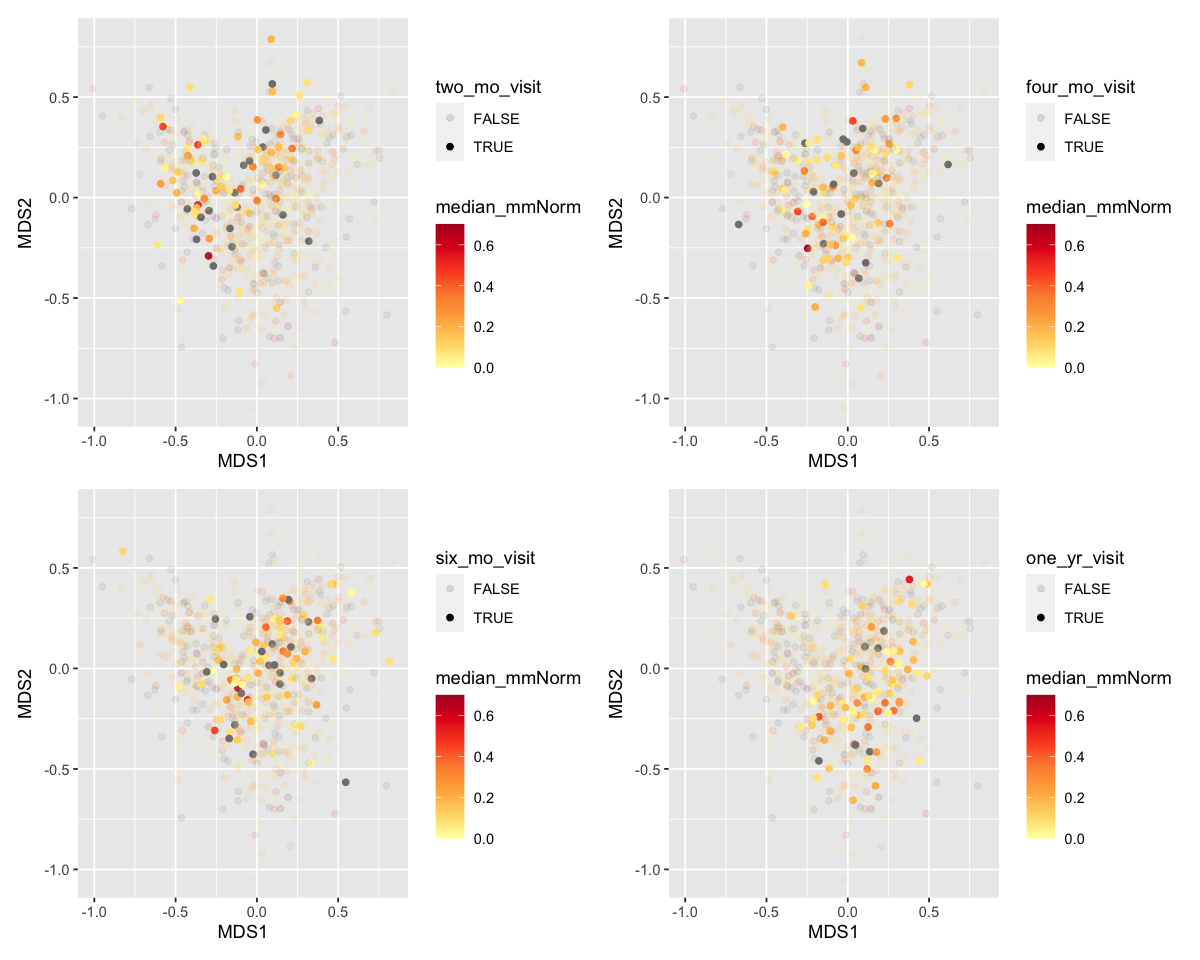

In [41]:
titer_two_month_plot = baby_samples_only %>% mutate('two_mo_visit' = VisitCode == 'V5') %>% ggplot(aes(x=MDS1, y=MDS2, color=median_mmNorm, alpha=two_mo_visit)) + geom_point() + scale_color_distiller(palette = 'YlOrRd', direction = 1)
titer_four_month_plot = baby_samples_only %>% mutate('four_mo_visit' = VisitCode == 'V6') %>% ggplot(aes(x=MDS1, y=MDS2, color=median_mmNorm, alpha=four_mo_visit)) + geom_point() + scale_color_distiller(palette = 'YlOrRd', direction = 1)
titer_six_month_plot = baby_samples_only %>% mutate('six_mo_visit' = VisitCode == 'V7') %>% ggplot(aes(x=MDS1, y=MDS2, color=median_mmNorm, alpha=six_mo_visit)) + geom_point() + scale_color_distiller(palette = 'YlOrRd', direction = 1)
titer_one_year_plot = baby_samples_only %>% mutate('one_yr_visit' = VisitCode == 'V9') %>% ggplot(aes(x=MDS1, y=MDS2, color=median_mmNorm, alpha=one_yr_visit)) + geom_point() + scale_color_distiller(palette = 'YlOrRd', direction = 1)
options(repr.plot.width = 10, repr.plot.height = 8)
titer_two_month_plot + titer_four_month_plot + titer_six_month_plot + titer_one_year_plot

No clustering by continuous titer either.

### Tests of assocation with LVR and NVR

#### 2 months

In [42]:
wilcox.test(baby_samples_only %>% filter(VisitCode == 'V5' & VR_group == 'LVR') %>% pull(MDS1),
            baby_samples_only %>% filter(VisitCode == 'V5' & VR_group == 'NVR') %>% pull(MDS1))


	Wilcoxon rank sum test with continuity correction

data:  baby_samples_only %>% filter(VisitCode == "V5" & VR_group == "LVR") %>% pull(MDS1) and baby_samples_only %>% filter(VisitCode == "V5" & VR_group == "NVR") %>% pull(MDS1)
W = 251, p-value = 0.6532
alternative hypothesis: true location shift is not equal to 0


In [43]:
wilcox.test(baby_samples_only %>% filter(VisitCode == 'V5' & VR_group == 'LVR') %>% pull(MDS2),
            baby_samples_only %>% filter(VisitCode == 'V5' & VR_group == 'NVR') %>% pull(MDS2))


	Wilcoxon rank sum test with continuity correction

data:  baby_samples_only %>% filter(VisitCode == "V5" & VR_group == "LVR") %>% pull(MDS2) and baby_samples_only %>% filter(VisitCode == "V5" & VR_group == "NVR") %>% pull(MDS2)
W = 237, p-value = 0.8652
alternative hypothesis: true location shift is not equal to 0


#### 4 months

In [44]:
wilcox.test(baby_samples_only %>% filter(VisitCode == 'V6' & VR_group == 'LVR') %>% pull(MDS1),
            baby_samples_only %>% filter(VisitCode == 'V6' & VR_group == 'NVR') %>% pull(MDS1))


	Wilcoxon rank sum test with continuity correction

data:  baby_samples_only %>% filter(VisitCode == "V6" & VR_group == "LVR") %>% pull(MDS1) and baby_samples_only %>% filter(VisitCode == "V6" & VR_group == "NVR") %>% pull(MDS1)
W = 306, p-value = 0.7241
alternative hypothesis: true location shift is not equal to 0


In [45]:
wilcox.test(baby_samples_only %>% filter(VisitCode == 'V6' & VR_group == 'LVR') %>% pull(MDS2),
            baby_samples_only %>% filter(VisitCode == 'V6' & VR_group == 'NVR') %>% pull(MDS2))


	Wilcoxon rank sum test with continuity correction

data:  baby_samples_only %>% filter(VisitCode == "V6" & VR_group == "LVR") %>% pull(MDS2) and baby_samples_only %>% filter(VisitCode == "V6" & VR_group == "NVR") %>% pull(MDS2)
W = 266, p-value = 0.7241
alternative hypothesis: true location shift is not equal to 0


#### 6 months

In [46]:
wilcox.test(baby_samples_only %>% filter(VisitCode == 'V7' & VR_group == 'LVR') %>% pull(MDS1),
            baby_samples_only %>% filter(VisitCode == 'V7' & VR_group == 'NVR') %>% pull(MDS1))


	Wilcoxon rank sum test with continuity correction

data:  baby_samples_only %>% filter(VisitCode == "V7" & VR_group == "LVR") %>% pull(MDS1) and baby_samples_only %>% filter(VisitCode == "V7" & VR_group == "NVR") %>% pull(MDS1)
W = 307, p-value = 0.868
alternative hypothesis: true location shift is not equal to 0


In [47]:
wilcox.test(baby_samples_only %>% filter(VisitCode == 'V7' & VR_group == 'LVR') %>% pull(MDS2),
            baby_samples_only %>% filter(VisitCode == 'V7' & VR_group == 'NVR') %>% pull(MDS2))


	Wilcoxon rank sum test with continuity correction

data:  baby_samples_only %>% filter(VisitCode == "V7" & VR_group == "LVR") %>% pull(MDS2) and baby_samples_only %>% filter(VisitCode == "V7" & VR_group == "NVR") %>% pull(MDS2)
W = 201, p-value = 0.09476
alternative hypothesis: true location shift is not equal to 0


#### 1 year

In [48]:
wilcox.test(baby_samples_only %>% filter(VisitCode == 'V9' & VR_group == 'LVR') %>% pull(MDS1),
            baby_samples_only %>% filter(VisitCode == 'V9' & VR_group == 'NVR') %>% pull(MDS1))


	Wilcoxon rank sum test with continuity correction

data:  baby_samples_only %>% filter(VisitCode == "V9" & VR_group == "LVR") %>% pull(MDS1) and baby_samples_only %>% filter(VisitCode == "V9" & VR_group == "NVR") %>% pull(MDS1)
W = 214, p-value = 0.356
alternative hypothesis: true location shift is not equal to 0


In [49]:
wilcox.test(baby_samples_only %>% filter(VisitCode == 'V9' & VR_group == 'LVR') %>% pull(MDS2),
            baby_samples_only %>% filter(VisitCode == 'V9' & VR_group == 'NVR') %>% pull(MDS2))


	Wilcoxon rank sum test with continuity correction

data:  baby_samples_only %>% filter(VisitCode == "V9" & VR_group == "LVR") %>% pull(MDS2) and baby_samples_only %>% filter(VisitCode == "V9" & VR_group == "NVR") %>% pull(MDS2)
W = 233, p-value = 0.5625
alternative hypothesis: true location shift is not equal to 0


### Tests of correlation between titer and diversity

#### 2 months

In [50]:
cor.test(baby_samples_only %>% filter(VisitCode == 'V5') %>% pull(MDS1),
         baby_samples_only %>% filter(VisitCode == 'V5') %>% pull(median_mmNorm),
         method='spearman')


	Spearman's rank correlation rho

data:  baby_samples_only %>% filter(VisitCode == "V5") %>% pull(MDS1) and baby_samples_only %>% filter(VisitCode == "V5") %>% pull(median_mmNorm)
S = 40160, p-value = 0.3306
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.1223776 


In [51]:
cor.test(baby_samples_only %>% filter(VisitCode == 'V5') %>% pull(MDS2),
         baby_samples_only %>% filter(VisitCode == 'V5') %>% pull(median_mmNorm),
         method='spearman')


	Spearman's rank correlation rho

data:  baby_samples_only %>% filter(VisitCode == "V5") %>% pull(MDS2) and baby_samples_only %>% filter(VisitCode == "V5") %>% pull(median_mmNorm)
S = 48538, p-value = 0.6302
alternative hypothesis: true rho is not equal to 0
sample estimates:
        rho 
-0.06070804 


In [52]:
cor.test(baby_samples_only %>% filter(VisitCode == 'V5') %>% pull(MDS1),
         baby_samples_only %>% filter(VisitCode == 'V5') %>% pull(median_mmNorm_DTAPHib),
         method='spearman')

Warning message in cor.test.default(baby_samples_only %>% filter(VisitCode == "V5") %>% :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  baby_samples_only %>% filter(VisitCode == "V5") %>% pull(MDS1) and baby_samples_only %>% filter(VisitCode == "V5") %>% pull(median_mmNorm_DTAPHib)
S = 36980, p-value = 0.1257
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.1918689 


In [53]:
cor.test(baby_samples_only %>% filter(VisitCode == 'V5') %>% pull(MDS2),
         baby_samples_only %>% filter(VisitCode == 'V5') %>% pull(median_mmNorm_DTAPHib),
         method='spearman')

Warning message in cor.test.default(baby_samples_only %>% filter(VisitCode == "V5") %>% :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  baby_samples_only %>% filter(VisitCode == "V5") %>% pull(MDS2) and baby_samples_only %>% filter(VisitCode == "V5") %>% pull(median_mmNorm_DTAPHib)
S = 48331, p-value = 0.6567
alternative hypothesis: true rho is not equal to 0
sample estimates:
        rho 
-0.05617486 


In [54]:
cor.test(baby_samples_only %>% filter(VisitCode == 'V5') %>% pull(MDS1),
         baby_samples_only %>% filter(VisitCode == 'V5') %>% pull(median_mmNorm_PCV),
         method='spearman')


	Spearman's rank correlation rho

data:  baby_samples_only %>% filter(VisitCode == "V5") %>% pull(MDS1) and baby_samples_only %>% filter(VisitCode == "V5") %>% pull(median_mmNorm_PCV)
S = 33908, p-value = 0.6599
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.0578494 


In [55]:
cor.test(baby_samples_only %>% filter(VisitCode == 'V5') %>% pull(MDS2),
         baby_samples_only %>% filter(VisitCode == 'V5') %>% pull(median_mmNorm_PCV),
         method='spearman')


	Spearman's rank correlation rho

data:  baby_samples_only %>% filter(VisitCode == "V5") %>% pull(MDS2) and baby_samples_only %>% filter(VisitCode == "V5") %>% pull(median_mmNorm_PCV)
S = 39118, p-value = 0.5081
alternative hypothesis: true rho is not equal to 0
sample estimates:
        rho 
-0.08691303 


#### 4 months

In [56]:
cor.test(baby_samples_only %>% filter(VisitCode == 'V6') %>% pull(MDS1),
         baby_samples_only %>% filter(VisitCode == 'V6') %>% pull(median_mmNorm),
         method='spearman')


	Spearman's rank correlation rho

data:  baby_samples_only %>% filter(VisitCode == "V6") %>% pull(MDS1) and baby_samples_only %>% filter(VisitCode == "V6") %>% pull(median_mmNorm)
S = 38128, p-value = 0.5074
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
0.08486943 


In [57]:
cor.test(baby_samples_only %>% filter(VisitCode == 'V6') %>% pull(MDS2),
         baby_samples_only %>% filter(VisitCode == 'V6') %>% pull(median_mmNorm),
         method='spearman')


	Spearman's rank correlation rho

data:  baby_samples_only %>% filter(VisitCode == "V6") %>% pull(MDS2) and baby_samples_only %>% filter(VisitCode == "V6") %>% pull(median_mmNorm)
S = 41156, p-value = 0.9244
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
0.01219278 


In [58]:
cor.test(baby_samples_only %>% filter(VisitCode == 'V6') %>% pull(MDS1),
         baby_samples_only %>% filter(VisitCode == 'V6') %>% pull(median_mmNorm_DTAPHib),
         method='spearman')

Warning message in cor.test.default(baby_samples_only %>% filter(VisitCode == "V6") %>% :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  baby_samples_only %>% filter(VisitCode == "V6") %>% pull(MDS1) and baby_samples_only %>% filter(VisitCode == "V6") %>% pull(median_mmNorm_DTAPHib)
S = 33988, p-value = 0.1483
alternative hypothesis: true rho is not equal to 0
sample estimates:
     rho 
0.184232 


In [59]:
cor.test(baby_samples_only %>% filter(VisitCode == 'V6') %>% pull(MDS2),
         baby_samples_only %>% filter(VisitCode == 'V6') %>% pull(median_mmNorm_DTAPHib),
         method='spearman')

Warning message in cor.test.default(baby_samples_only %>% filter(VisitCode == "V6") %>% :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  baby_samples_only %>% filter(VisitCode == "V6") %>% pull(MDS2) and baby_samples_only %>% filter(VisitCode == "V6") %>% pull(median_mmNorm_DTAPHib)
S = 45891, p-value = 0.4288
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
-0.1014548 


In [60]:
cor.test(baby_samples_only %>% filter(VisitCode == 'V6') %>% pull(MDS1),
         baby_samples_only %>% filter(VisitCode == 'V6') %>% pull(median_mmNorm_PCV),
         method='spearman')


	Spearman's rank correlation rho

data:  baby_samples_only %>% filter(VisitCode == "V6") %>% pull(MDS1) and baby_samples_only %>% filter(VisitCode == "V6") %>% pull(median_mmNorm_PCV)
S = 32548, p-value = 0.993
alternative hypothesis: true rho is not equal to 0
sample estimates:
         rho 
-0.001199668 


In [61]:
cor.test(baby_samples_only %>% filter(VisitCode == 'V6') %>% pull(MDS2),
         baby_samples_only %>% filter(VisitCode == 'V6') %>% pull(median_mmNorm_PCV),
         method='spearman')


	Spearman's rank correlation rho

data:  baby_samples_only %>% filter(VisitCode == "V6") %>% pull(MDS2) and baby_samples_only %>% filter(VisitCode == "V6") %>% pull(median_mmNorm_PCV)
S = 32904, p-value = 0.9278
alternative hypothesis: true rho is not equal to 0
sample estimates:
        rho 
-0.01215048 


#### 6 months

In [62]:
cor.test(baby_samples_only %>% filter(VisitCode == 'V7') %>% pull(MDS1),
         baby_samples_only %>% filter(VisitCode == 'V7') %>% pull(median_mmNorm),
         method='spearman')

Warning message in cor.test.default(baby_samples_only %>% filter(VisitCode == "V7") %>% :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  baby_samples_only %>% filter(VisitCode == "V7") %>% pull(MDS1) and baby_samples_only %>% filter(VisitCode == "V7") %>% pull(median_mmNorm)
S = 44669, p-value = 0.8505
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
0.02384204 


In [63]:
cor.test(baby_samples_only %>% filter(VisitCode == 'V7') %>% pull(MDS2),
         baby_samples_only %>% filter(VisitCode == 'V7') %>% pull(median_mmNorm),
         method='spearman')

Warning message in cor.test.default(baby_samples_only %>% filter(VisitCode == "V7") %>% :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  baby_samples_only %>% filter(VisitCode == "V7") %>% pull(MDS2) and baby_samples_only %>% filter(VisitCode == "V7") %>% pull(median_mmNorm)
S = 43264, p-value = 0.6661
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
0.05454605 


In [64]:
cor.test(baby_samples_only %>% filter(VisitCode == 'V7') %>% pull(MDS1),
         baby_samples_only %>% filter(VisitCode == 'V7') %>% pull(median_mmNorm_DTAPHib),
         method='spearman')

Warning message in cor.test.default(baby_samples_only %>% filter(VisitCode == "V7") %>% :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  baby_samples_only %>% filter(VisitCode == "V7") %>% pull(MDS1) and baby_samples_only %>% filter(VisitCode == "V7") %>% pull(median_mmNorm_DTAPHib)
S = 42363, p-value = 0.5568
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
0.07422951 


In [65]:
cor.test(baby_samples_only %>% filter(VisitCode == 'V7') %>% pull(MDS2),
         baby_samples_only %>% filter(VisitCode == 'V7') %>% pull(median_mmNorm_DTAPHib),
         method='spearman')

Warning message in cor.test.default(baby_samples_only %>% filter(VisitCode == "V7") %>% :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  baby_samples_only %>% filter(VisitCode == "V7") %>% pull(MDS2) and baby_samples_only %>% filter(VisitCode == "V7") %>% pull(median_mmNorm_DTAPHib)
S = 42903, p-value = 0.6213
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
0.06242623 


In [66]:
cor.test(baby_samples_only %>% filter(VisitCode == 'V7') %>% pull(MDS1),
         baby_samples_only %>% filter(VisitCode == 'V7') %>% pull(median_mmNorm_PCV),
         method='spearman')


	Spearman's rank correlation rho

data:  baby_samples_only %>% filter(VisitCode == "V7") %>% pull(MDS1) and baby_samples_only %>% filter(VisitCode == "V7") %>% pull(median_mmNorm_PCV)
S = 38866, p-value = 0.8321
alternative hypothesis: true rho is not equal to 0
sample estimates:
        rho 
-0.02765732 


In [67]:
cor.test(baby_samples_only %>% filter(VisitCode == 'V7') %>% pull(MDS2),
         baby_samples_only %>% filter(VisitCode == 'V7') %>% pull(median_mmNorm_PCV),
         method='spearman')


	Spearman's rank correlation rho

data:  baby_samples_only %>% filter(VisitCode == "V7") %>% pull(MDS2) and baby_samples_only %>% filter(VisitCode == "V7") %>% pull(median_mmNorm_PCV)
S = 39586, p-value = 0.7202
alternative hypothesis: true rho is not equal to 0
sample estimates:
        rho 
-0.04669487 


#### 1 year

In [68]:
cor.test(baby_samples_only %>% filter(VisitCode == 'V9') %>% pull(MDS1),
         baby_samples_only %>% filter(VisitCode == 'V9') %>% pull(median_mmNorm),
         method='spearman')


	Spearman's rank correlation rho

data:  baby_samples_only %>% filter(VisitCode == "V9") %>% pull(MDS1) and baby_samples_only %>% filter(VisitCode == "V9") %>% pull(median_mmNorm)
S = 51578, p-value = 0.8995
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.0155743 


In [69]:
cor.test(baby_samples_only %>% filter(VisitCode == 'V9') %>% pull(MDS2),
         baby_samples_only %>% filter(VisitCode == 'V9') %>% pull(median_mmNorm),
         method='spearman')


	Spearman's rank correlation rho

data:  baby_samples_only %>% filter(VisitCode == "V9") %>% pull(MDS2) and baby_samples_only %>% filter(VisitCode == "V9") %>% pull(median_mmNorm)
S = 62196, p-value = 0.1264
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
-0.1870825 


In [70]:
cor.test(baby_samples_only %>% filter(VisitCode == 'V9') %>% pull(MDS1),
         baby_samples_only %>% filter(VisitCode == 'V9') %>% pull(median_mmNorm_DTAPHib),
         method='spearman')

Warning message in cor.test.default(baby_samples_only %>% filter(VisitCode == "V9") %>% :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  baby_samples_only %>% filter(VisitCode == "V9") %>% pull(MDS1) and baby_samples_only %>% filter(VisitCode == "V9") %>% pull(median_mmNorm_DTAPHib)
S = 40832, p-value = 0.07055
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.2206761 


In [71]:
cor.test(baby_samples_only %>% filter(VisitCode == 'V9') %>% pull(MDS2),
         baby_samples_only %>% filter(VisitCode == 'V9') %>% pull(median_mmNorm_DTAPHib),
         method='spearman')

Warning message in cor.test.default(baby_samples_only %>% filter(VisitCode == "V9") %>% :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  baby_samples_only %>% filter(VisitCode == "V9") %>% pull(MDS2) and baby_samples_only %>% filter(VisitCode == "V9") %>% pull(median_mmNorm_DTAPHib)
S = 51967, p-value = 0.9474
alternative hypothesis: true rho is not equal to 0
sample estimates:
        rho 
0.008150566 


In [72]:
cor.test(baby_samples_only %>% filter(VisitCode == 'V9') %>% pull(MDS1),
         baby_samples_only %>% filter(VisitCode == 'V9') %>% pull(median_mmNorm_PCV),
         method='spearman')


	Spearman's rank correlation rho

data:  baby_samples_only %>% filter(VisitCode == "V9") %>% pull(MDS1) and baby_samples_only %>% filter(VisitCode == "V9") %>% pull(median_mmNorm_PCV)
S = 44962, p-value = 0.5365
alternative hypothesis: true rho is not equal to 0
sample estimates:
        rho 
-0.07915707 


In [73]:
cor.test(baby_samples_only %>% filter(VisitCode == 'V9') %>% pull(MDS2),
         baby_samples_only %>% filter(VisitCode == 'V9') %>% pull(median_mmNorm_PCV),
         method='spearman')


	Spearman's rank correlation rho

data:  baby_samples_only %>% filter(VisitCode == "V9") %>% pull(MDS2) and baby_samples_only %>% filter(VisitCode == "V9") %>% pull(median_mmNorm_PCV)
S = 50146, p-value = 0.1095
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
-0.203581 
